# Code Automation Notebook

## What this notebook does
This notebook is a is made for loading, cleaning, plotting, and exporting IV (current–voltage) data from raw **`.txt` files (e.g. from the B1500)** 
It is designed to work in steps, so you can follow the process or reuse parts for other datasets.

### Core Features
1. **File Collection**  
   - Automatically finds all `.txt` files inside your chosen device folder and subfolders.  
   - Skips helper files like `index.txt` (B1500 always outputs this, ignore it to avoid errors).

2. **Data Loading**  
   - Reads voltage/current columns into `pandas` DataFrames.  
   - Normalizes headers to `"V"` and `"I"` for consistency.  

3. **Data Extraction**  
   - Flattens the nested folder/file structure into a single dictionary `final_data` with easy-to-use labels like:  
     - `"V_Measurment3txt_TLM1"`  
     - `"I_Measurment3txt_TLM1"`
     - This follows the format of "V_filenametxt_foldername", where filename has no symbols such as _, ., or - 

4. **Quick Plotting**  
   - `plot_multiple_iv`: plot one or more IV sweeps on the same figure, fit a line, and report resistance values.  

5. **TLM (Transfer Length Method) Example**  
   - Shows how to combine resistances vs. spacing into TLM plots.  
   - Supports outlier filtering (single and double MAD filters).  
   - Extracts key parameters:  
     - Sheet resistance $R_s$ (Ω/□)  
     - Contact resistance $R_c$ (Ω)

6. **Excel Export**  
   - Save individual IV sweeps to Excel.  
   - Save all sweeps from a device folder into one Excel file with multiple sheets.  
   - Optionally, save processed TLM results.

---

## How to use this notebook
1. **Set your root directory**  
   Point `root_dir` to where your device folders live (e.g. `...20250710\TLM DATA`).

2. **Pick your device(s) and subfolders**  
   - `devices = ["4.1", "4.2", ...]`  
   - `subfolders = ["TLM1", "TLM2", "TLM3", "TLM4"]`

3. **Run the extraction**  
   - Use `run_device` to collect → load → extract → plot IV sweeps.  
   - Use `collect_all_spacing_R` and `plot_all_tlm_one_figure` to generate combined TLM plots.

4. **Export results**  
   - Use the Excel export cells to save any IV sweep (or all sweeps) into Excel for reporting/sharing.


## Example: TLM Workflow
The notebook demonstrates everything using **TLM measurements**:  
- Each subfolder (`TLM1`–`TLM4`) corresponds to one set of test structures.  
- Each `.txt` file inside corresponds to an IV sweep at a different spacing.  
- By fitting IV curves and collecting $R$ values across spacings, the code builds full TLM plots.  

Even though TLMs are used as the worked example, thi is for general purpose:  
you can adapt it to any IV dataset with `.txt` files that have voltage and current columns.

---

## Outputs you’ll get
- IV sweeps for any chosen label or group of labels.  
- Tidy linear fits with resistances printed to console.  
- Combined TLM plots (all devices or subsets).  
- Excel exports with one sheet per IV sweep for easy sharing.  

## Customizing Plots
Plots are generated with **[matplotlib](https://matplotlib.org/stable/contents.html)**.  

You can easily change the look of your plots by:
- Adjusting **colors**: edit the `colors` list at the top of the code (e.g. `["red", "blue", "green"]`).  
- Changing **markers/line styles**: add arguments like `plt.plot(V, I, "o--")` for circle markers with dashed lines.  
- Tweaking **figure size**: use `plt.figure(figsize=(8,6))` for bigger or smaller plots.  
- Setting **plot style** globally: `plt.style.use("seaborn-v0_8")`, `"ggplot"`, or `"classic"`.  

This gives you full control over the aesthetics.

If you have any questions please email Julia at juliapedroso13@gmail.com

I hope this is useful and I'd like to thank all of you for the wonderful time I had during this internship!!


In [39]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib.lines import Line2D


# COLOR SETTINGS
# Pick your line colors here. The plots will cycle through this list.
# Change or reorder these to match your style.
colors = ["red", "orange", "gold", "limegreen", "green",
        "deepskyblue", "blue", "purple", "pink"]
#colors = ["purple", "blue" ,"deepskyblue", "green", "limegreen","gold","orange","red"]

'''
STEP 1: COLLECT ALL .TXT FILENAMES

This def will walk through a list of subfolders, find all .txt files (skip anything with "index" in the name), 
and return a dict like:
   {"MyFolderNameClean": ["file1.txt", "file2.txt", ...], ...}

We clean the keys so they are short and safe to use as labels later.
'''
def collect_txt_files(base_path, subfolders):
    txt_files = {}
    for sf in subfolders:
        # Build absolute path to this subfolder
        full = os.path.normpath(os.path.join(base_path, sf))
        # Clean folder name for dict key
        key = sf.replace("/", "_").replace(" ", "")
        txt_files[key] = []
        try:
            # Scan the folder for files
            with os.scandir(full) as it:
                for f in it:
                    # Only take .txt files, ignore helper "index" files
                    if f.name.endswith(".txt") and "index" not in f.name:
                        txt_files[key].append(f.name)
        except FileNotFoundError:
            # Missing folder will not crash the script
            print(f"Folder not found: {full}")
    return txt_files


'''
COLUMN NAME MAPPINGS

Different exports may call the same thing by different names.
Here we define possible pairs of column names that represent Voltage and Current.

Each entry is: ([raw_col_name_volt, raw_col_name_curr], ["V", "I"])

The right side is the standardized names we will use everywhere else.
'''
COLUMN_SETS = [
    (["V_bias", "I_Source"], ["V", "I"]),
    (["longitudinal", "I2"], ["V", "I"]),
    (["V_cap", "I_leakage"], ["V", "I"]),
    (["longitudinal", "I3"], ["V", "I"]),
    (["longitudinal", "I4"], ["V", "I"]),
    (["longitudinal", "I1"], ["V", "I"]),
    # Add more here if your files use other headers
]


"""
STEP 2: LOAD A SINGLE FILE

Goal: try to read one data file by looping over COLUMN_SETS.
 - If a matching column set is found, rename them to "V" and "I"
 - Drop NaN rows
 - Cast to floats

Returns a pandas DataFrame with columns ["V","I"], or None if no match found.
"""
def load_one_file(path, skiprows=6):
    for cols, std_names in COLUMN_SETS:
        try:
            df = pd.read_csv(path, skiprows=skiprows, usecols=cols)
            # Normalize column names to "V" and "I"
            df.columns = std_names
            # Drop NaN values
            df = df.dropna(subset=std_names)
            # Ensure numeric
            df = df.astype({std_names[0]: float, std_names[1]: float})
            return df
        except ValueError:
            # This file does not contain that pair of columns, then try next one
            continue
    print(f"{path}: no matching column set found")
    return None


"""
STEP 2: LOAD ALL DATA INTO DATAFRAMES

Thie def will go over every file in every subfolder, and load it into a DataFrame using load_one_file.
Output structure:
   {"FolderKey": {"filename.txt": DataFrame(V,I), ...}, ...}
"""
def load_txt_data(txt_files, base_path, subfolders):
    key_data = {}
    for sf in subfolders:
        key = sf.replace("/", "_").replace(" ", "")
        fold = os.path.normpath(os.path.join(base_path, sf))
        key_data[key] = {}
        # Loop over files in this folder
        for fname in txt_files.get(key, []):
            path = os.path.join(fold, fname)
            df = load_one_file(path, skiprows=6)   # uses COLUMN_SETS
            if df is not None:
                key_data[key][fname] = df
    return key_data


"""
STEP 3: ORGANIZE INTO A FLAT DICTIONARY OF NUMPY ARRAYS

This def will convert the nested dict into a single flat dict with clean labels. Keys will look like:
   "V_<filename>_<folderKey>"
   "I_<filename>_<folderKey>"

This makes it easy to fetch V/I pairs later by name.
"""
def extract_final_data(key_data):
    final = {}
    for key, dfs in key_data.items():
        # Clean folder key
        clean_key = re.sub(r'[_.\s]', '', key)
        for fname, df in dfs.items():
            # Clean file name (remove separators, dots, and ".txt")
            clean_fname = re.sub(r'[_.\s-]|\.txt', '', fname)
            label = f"{clean_fname}_{clean_key}"
            # Save voltage and current arrays under predictable names
            final[f"V_{label}"] = df['V'].to_numpy(float)
            final[f"I_{label}"] = df['I'].to_numpy(float)
    return final


"""
STEP 4: QUICK LABEL LISTING

Goal: print some of the valid labels so you can copy-paste them into the plotting call.
"""
def list_labels(final_data, n=15):
    print("First few valid labels:")
    # Keys come in pairs (V_xxx, I_xxx). Step by 2 to only show one of each.
    for k in list(final_data.keys())[:2*n:2]:
        print("   ", k[2:])  # Strip "V_" prefix to show just the label core


"""
STEP 5: PLOTTING FUNCTION

plot_multiple_iv:
 - Plots one or more I vs V curves on the same axes
 - Fits a straight line I = m*V + b for each label
 - Reports slope (A/V) and resistance (Ω)
 - Optional xlim/ylim to zoom or crop the data
"""
def plot_multiple_iv(final_data, *,
                     labels=None,
                     legend_names=None,
                     title="IV Sweep",
                     xlim=None,
                     ylim=None,):      

    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    results = {}  # Store fit results per label

    # Loop through each requested curve
    for i, (lab, leg) in enumerate(zip(labels, legend_names)):
        # Fetch voltage/current arrays
        V = final_data.get(f"V_{lab}")
        I = final_data.get(f"I_{lab}")
        if V is None or I is None:
            print(f"'{lab}' not found, skipping.")
            continue

        # Optional cropping by xlim
        if xlim:
            mask = (V >= xlim[0]) & (V <= xlim[1])
            V = V[mask]
            I = I[mask]

        # Fit a straight line if there are enough points
        if len(V) > 1:
            slope, intercept = np.polyfit(V, I, 1)  # I = slope*V + intercept
            R = np.inf if slope == 0 else 1.0 / slope  # Resistance = 1/slope
            results[lab] = {
                "slope_A_per_V": slope,
                "R_ohm": R,
            }
        else:
            # Not enough data to fit
            results[lab] = {
                "slope_A_per_V": np.nan,
                "R_ohm": np.nan,
            }

        # Plot this curve
        ax.plot(V, I, color=colors[i % len(colors)], label=leg)

    # Apply axis ranges if given
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)

    # Axis labels and styling
    ax.set_xlabel("Voltage [V]")
    ax.set_ylabel("Current [A]")
    ax.ticklabel_format(axis='y', style='sci')
    ax.ticklabel_format(axis='x', style='sci')
    ax.set_title(title)

    # Draw zero reference lines
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')

    # Light background
    ax.set_facecolor('#f5f5f5')

    # Legend + tidy layout
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Print summary of slopes and resistances
    for lab, vals in results.items():
        if np.isfinite(vals.get("R_ohm", np.nan)):
            print(
                f"{lab}: slope = {vals['slope_A_per_V']:.6g} A/V, ",
                f"R = {np.abs(vals['R_ohm']):.6g} Ω, ",
                end=""
            )
        else:
            print(f"{lab}: insufficient points for fit")

    return results


"""
STEP 6: AUTO RUNNER

run_device:
 - Collects .txt files
 - Loads them into DataFrames
 - Extracts clean NumPy arrays with labels
 - Calls the plotting function

Easy to do everything in one go
"""
def run_device(device_dir, subfolders, labels, legend_names, *, title="", xlim=None, ylim=None):
    # Step 1: find files
    txt_files  = collect_txt_files(device_dir, subfolders)
    # Step 2: load data into DataFrames
    key_data   = load_txt_data(txt_files, device_dir, subfolders)
    # Step 3: flatten into V/I arrays
    final_data = extract_final_data(key_data)

    # Optional: print some labels if needed
    # list_labels(final_data, n=50)

    # Step 4: plot and return results
    results = plot_multiple_iv(
        final_data,
        labels=labels,
        legend_names=legend_names,
        title=title,
        xlim=xlim,
        ylim=ylim,
        )
    return results


C:\Users\julia\OneDrive\Documents\Work\tyndall\python\TLM DATA\4.1\TLM1\ORDER.txt: no matching column set found
First few valid labels:
    Measurment2txt_TLM1
    Measurment3txt_TLM1
    Measurment4txt_TLM1
    Measurment5txt_TLM1
    Measurment6txt_TLM1
    Measurment7txt_TLM1
    Measurment8txt_TLM1
    Measurmenttxt_TLM1
    Measurment2txt_TLM2
    Measurment3txt_TLM2
    Measurment4txt_TLM2
    Measurment5txt_TLM2
    Measurment6txt_TLM2
    Measurment7txt_TLM2
    Measurment8txt_TLM2
    Measurmenttxt_TLM2
    Measurment2txt_TLM3
    Measurment3txt_TLM3
    Measurment4txt_TLM3
    Measurment5txt_TLM3
    Measurment6txt_TLM3
    Measurment7txt_TLM3
    Measurment8txt_TLM3
    Measurmenttxt_TLM3
    Measurment2txt_TLM4
    Measurment3txt_TLM4
    Measurment4txt_TLM4
    Measurment5txt_TLM4
    Measurment6txt_TLM4
    Measurment7txt_TLM4
I = [-8.875420e-04 -8.699050e-04 -8.529180e-04 -8.358490e-04 -8.184890e-04
 -8.010580e-04 -7.835360e-04 -7.664410e-04 -7.494430e-04 -7.318240e-04
 

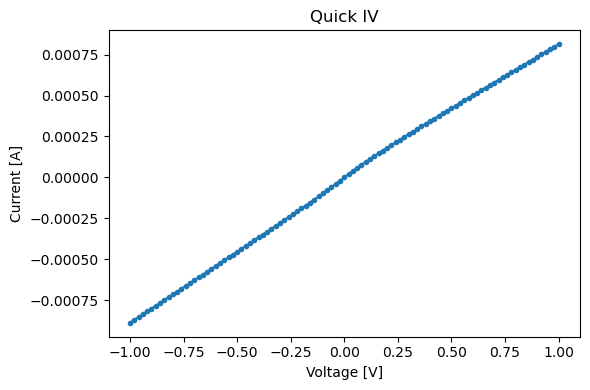

In [26]:
#QUICKLY GETTING DATA FROM ONE DEVICE 

# 1) Choose one device directory to inspect
#    Here, device "4.1" has four TLM subfolders.
#    NOTE: change this path if you want to test another device.
device_dir = r"C:\Users\julia\OneDrive\Documents\Work\tyndall\python\TLM DATA\4.1"
subfolders = ["TLM1","TLM2","TLM3","TLM4"]

# 2) Collect → load → extract
#    - collect_txt_files: finds all .txt files inside the subfolders
#    - load_txt_data: reads them into pandas DataFrames
#    - extract_final_data: flattens into final_data dict with "V_label" and "I_label" arrays
txt_files  = collect_txt_files(device_dir, subfolders)
key_data   = load_txt_data(txt_files, device_dir, subfolders)
final_data = extract_final_data(key_data)

# 3) Sanity check:
#    Print the first 30 available labels so you know what you can call by name.
#    Useful for copy-paste into plotting/analysis functions.
list_labels(final_data, n=30)


# 4) Manually pull out one curve by label
#    Here we grab "Measurement3" from TLM1 and fetch its V and I arrays.
V = final_data.get(f"V_Measurment3txt_TLM1")
I = final_data.get(f"I_Measurment3txt_TLM1")

# 5) Print the raw arrays to the console (optional)
print(f"I = {I}")
print(f"V = {V}")

# 6) Compute the instantaneous resistance point by point
#    (R = V/I). This is a rough check, not a linear fit.
R = V / I
print(R)

# 7) Quick plot of this single IV curve
plt.figure(figsize=(6,4))
plt.plot(V, I, ".-")   # dots connected by lines
plt.xlabel("Voltage [V]")
plt.ylabel("Current [A]")
plt.title(f"Quick IV")
plt.tight_layout()
plt.show()


In [33]:

# EXPORT IV DATA TO EXCEL (ONE OR MANY)

"""
This cell shows two approaches:

1) Export a single IV curve (one label) into its own Excel file,
   saved in a folder of your choice.

2) Export all IV curves from final_data into one Excel workbook,
   with each curve in its own sheet.

You can adapt the save_dir to point to wherever you want.
"""

# ---------- SETTINGS ----------
save_dir = r"C:\Users\julia\OneDrive\Documents\Work\tyndall\python\excel"
os.makedirs(save_dir, exist_ok=True)   # make sure folder exists

# ---------- (1) SAVE ONE LABEL ----------
label = "Measurment3txt_TLM1"   # pick the label you want to export
V = final_data.get(f"V_{label}")
I = final_data.get(f"I_{label}")

df = pd.DataFrame({
    "Voltage [V]": V,
    "Current [A]": I,
})

single_output_path = os.path.join(save_dir, f"{label}.xlsx")
df.to_excel(single_output_path, sheet_name="IV_data", index=False)

print(f"Saved single measurement to: {single_output_path}")


# ---------- (2) SAVE ALL LABELS ----------
all_output_path = os.path.join(save_dir, "all_measurements_4.1.xlsx")

with pd.ExcelWriter(all_output_path, engine="openpyxl") as writer:
    for key in final_data.keys():
        if key.startswith("V_"):   # only process voltage keys
            label = key[2:]        # strip "V_" prefix
            V = final_data[f"V_{label}"]
            I = final_data[f"I_{label}"]

            df = pd.DataFrame({
                "Voltage [V]": V,
                "Current [A]": I,
            })

            # Excel sheet names max length = 31 chars
            df.to_excel(writer, sheet_name=label[:30], index=False)

print(f"Saved all measurements into one workbook: {all_output_path}")


# NOTES
"""
- Change save_dir to wherever you want the Excel files saved.
- Approach (1): Good if you only want to export one IV curve.
- Approach (2): Good for archiving everything — one sheet per curve.

Tips:
 * Use label[:30] to avoid Excel’s 31-char sheet name limit.
 * You can add a timestamp to filenames if you don’t want to overwrite old exports.
"""


Saved single measurement to: C:\Users\julia\OneDrive\Documents\Work\tyndall\python\excel\Measurment3txt_TLM1.xlsx
Saved all measurements into one workbook: C:\Users\julia\OneDrive\Documents\Work\tyndall\python\excel\all_measurements_4.1.xlsx


'\n- Change save_dir to wherever you want the Excel files saved.\n- Approach (1): Good if you only want to export one IV curve.\n- Approach (2): Good for archiving everything — one sheet per curve.\n\nTips:\n * Use label[:30] to avoid Excel’s 31-char sheet name limit.\n * You can add a timestamp to filenames if you don’t want to overwrite old exports.\n'


=== 4.1 | TLM1 ===
C:\Users\julia\OneDrive\Documents\Work\tyndall\python\TLM DATA\4.1\TLM1\ORDER.txt: no matching column set found


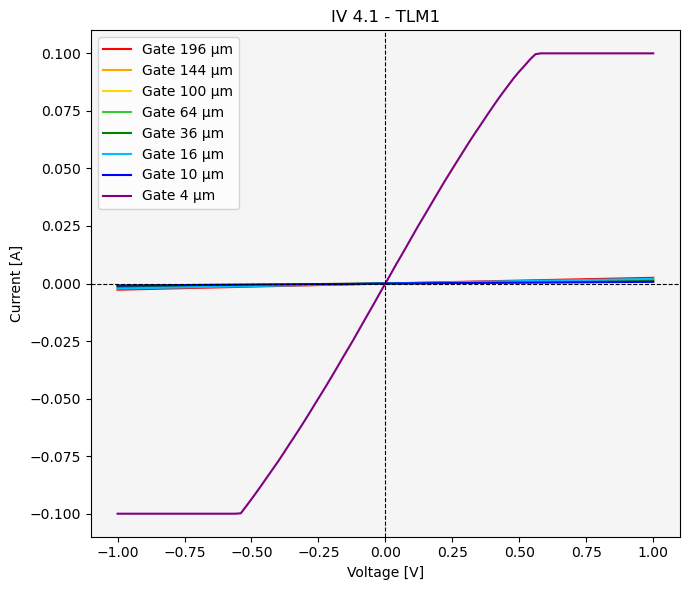

Measurment2txt_TLM1: slope = 0.00259543 A/V,  R = 385.292 Ω, Measurment3txt_TLM1: slope = 0.000862225 A/V,  R = 1159.79 Ω, Measurment4txt_TLM1: slope = 0.000997202 A/V,  R = 1002.81 Ω, Measurment5txt_TLM1: slope = 0.00121023 A/V,  R = 826.288 Ω, Measurment6txt_TLM1: slope = 0.00152918 A/V,  R = 653.944 Ω, Measurment7txt_TLM1: slope = 0.00213642 A/V,  R = 468.073 Ω, Measurmenttxt_TLM1: slope = 0.000812844 A/V,  R = 1230.25 Ω, Measurment8txt_TLM1: slope = 0.135269 A/V,  R = 7.39269 Ω, 
=== 4.1 | TLM2 ===
C:\Users\julia\OneDrive\Documents\Work\tyndall\python\TLM DATA\4.1\TLM1\ORDER.txt: no matching column set found


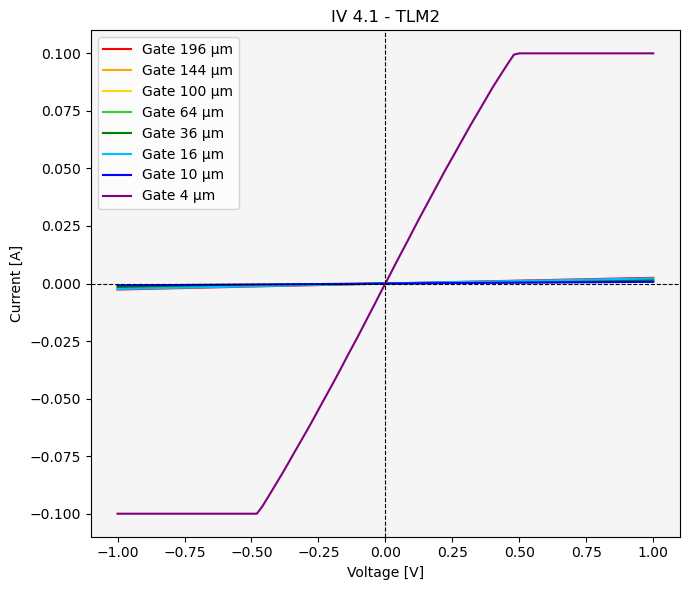

Measurment2txt_TLM2: slope = 0.00255825 A/V,  R = 390.892 Ω, Measurment3txt_TLM2: slope = 0.000853275 A/V,  R = 1171.96 Ω, Measurment4txt_TLM2: slope = 0.000961504 A/V,  R = 1040.04 Ω, Measurment5txt_TLM2: slope = 0.00123711 A/V,  R = 808.334 Ω, Measurment6txt_TLM2: slope = 0.0016337 A/V,  R = 612.106 Ω, Measurment7txt_TLM2: slope = 0.00232106 A/V,  R = 430.837 Ω, Measurmenttxt_TLM2: slope = 0.000784004 A/V,  R = 1275.5 Ω, Measurment8txt_TLM2: slope = 0.137992 A/V,  R = 7.2468 Ω, 
=== 4.1 | TLM3 ===
C:\Users\julia\OneDrive\Documents\Work\tyndall\python\TLM DATA\4.1\TLM1\ORDER.txt: no matching column set found


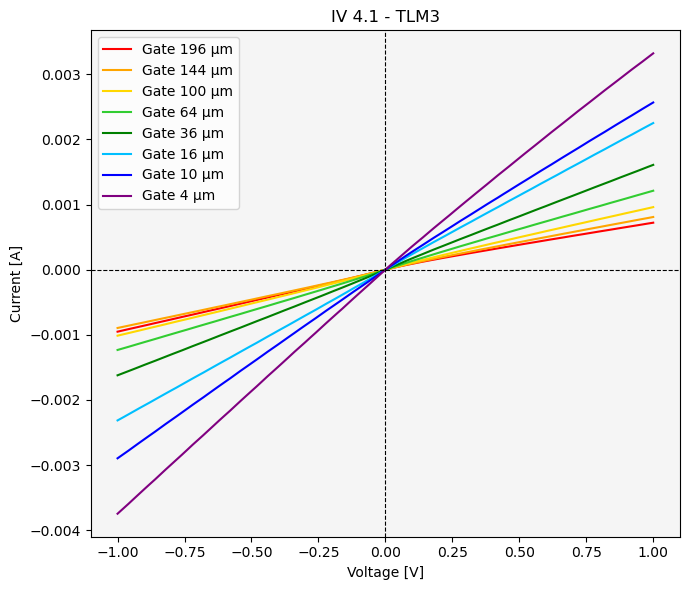

Measurment2txt_TLM3: slope = 0.000850297 A/V,  R = 1176.06 Ω, Measurment3txt_TLM3: slope = 0.000866167 A/V,  R = 1154.51 Ω, Measurment4txt_TLM3: slope = 0.00100101 A/V,  R = 998.996 Ω, Measurment5txt_TLM3: slope = 0.00123622 A/V,  R = 808.916 Ω, Measurment6txt_TLM3: slope = 0.00162832 A/V,  R = 614.13 Ω, Measurment7txt_TLM3: slope = 0.00229438 A/V,  R = 435.848 Ω, Measurmenttxt_TLM3: slope = 0.00274006 A/V,  R = 364.955 Ω, Measurment8txt_TLM3: slope = 0.00355684 A/V,  R = 281.149 Ω, 
=== 4.1 | TLM4 ===
C:\Users\julia\OneDrive\Documents\Work\tyndall\python\TLM DATA\4.1\TLM1\ORDER.txt: no matching column set found


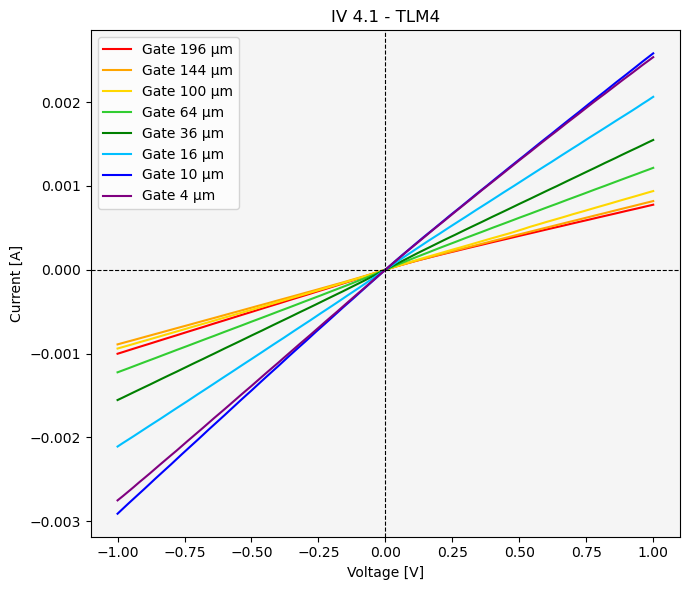

Measurment2txt_TLM4: slope = 0.000897629 A/V,  R = 1114.05 Ω, Measurment3txt_TLM4: slope = 0.000864304 A/V,  R = 1157 Ω, Measurment4txt_TLM4: slope = 0.000945644 A/V,  R = 1057.48 Ω, Measurment5txt_TLM4: slope = 0.00122947 A/V,  R = 813.356 Ω, Measurment6txt_TLM4: slope = 0.00156077 A/V,  R = 640.711 Ω, Measurment7txt_TLM4: slope = 0.00209621 A/V,  R = 477.052 Ω, Measurmenttxt_TLM4: slope = 0.00275149 A/V,  R = 363.44 Ω, Measurment8txt_TLM4: slope = 0.00266937 A/V,  R = 374.621 Ω, 
=== 4.2 | TLM1 ===


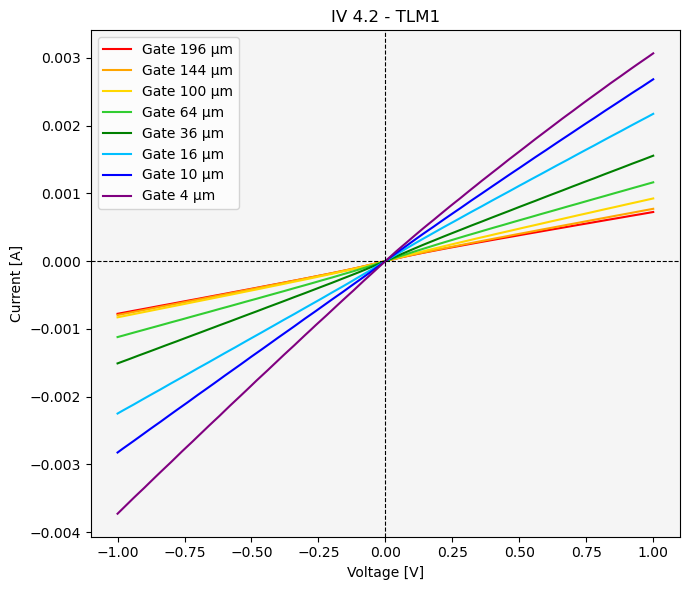

Measurment2txt_TLM1: slope = 0.000769036 A/V,  R = 1300.33 Ω, Measurment3txt_TLM1: slope = 0.000798496 A/V,  R = 1252.36 Ω, Measurment4txt_TLM1: slope = 0.000893187 A/V,  R = 1119.59 Ω, Measurment5txt_TLM1: slope = 0.00115851 A/V,  R = 863.178 Ω, Measurment6txt_TLM1: slope = 0.00154935 A/V,  R = 645.431 Ω, Measurment7txt_TLM1: slope = 0.0022288 A/V,  R = 448.671 Ω, Measurmenttxt_TLM1: slope = 0.00276852 A/V,  R = 361.204 Ω, Measurment8txt_TLM1: slope = 0.0034248 A/V,  R = 291.987 Ω, 
=== 4.2 | TLM2 ===


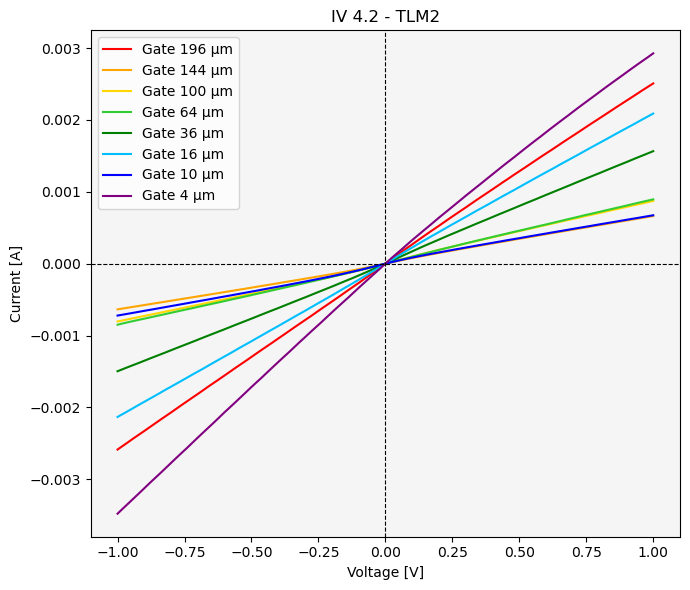

Measurment2txt_TLM2: slope = 0.00256347 A/V,  R = 390.096 Ω, Measurment3txt_TLM2: slope = 0.0006632 A/V,  R = 1507.84 Ω, Measurment4txt_TLM2: slope = 0.000853739 A/V,  R = 1171.32 Ω, Measurment5txt_TLM2: slope = 0.000882412 A/V,  R = 1133.26 Ω, Measurment6txt_TLM2: slope = 0.00154747 A/V,  R = 646.217 Ω, Measurment7txt_TLM2: slope = 0.00212607 A/V,  R = 470.35 Ω, Measurmenttxt_TLM2: slope = 0.000718774 A/V,  R = 1391.26 Ω, Measurment8txt_TLM2: slope = 0.00322938 A/V,  R = 309.657 Ω, 
=== 4.2 | TLM3 ===


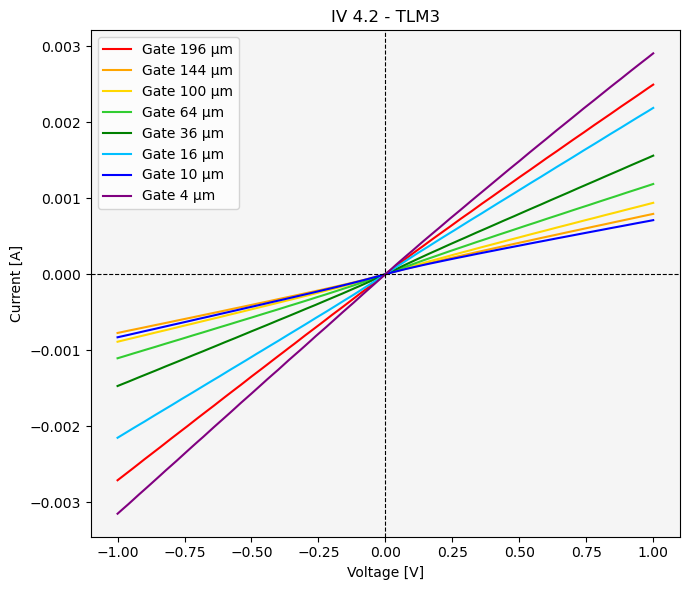

Measurment2txt_TLM3: slope = 0.00261154 A/V,  R = 382.915 Ω, Measurment3txt_TLM3: slope = 0.000798977 A/V,  R = 1251.6 Ω, Measurment4txt_TLM3: slope = 0.000928863 A/V,  R = 1076.58 Ω, Measurment5txt_TLM3: slope = 0.00116137 A/V,  R = 861.054 Ω, Measurment6txt_TLM3: slope = 0.00152922 A/V,  R = 653.927 Ω, Measurment7txt_TLM3: slope = 0.00218175 A/V,  R = 458.348 Ω, Measurmenttxt_TLM3: slope = 0.000786632 A/V,  R = 1271.24 Ω, Measurment8txt_TLM3: slope = 0.00304424 A/V,  R = 328.489 Ω, 
=== 4.2 | TLM4 ===


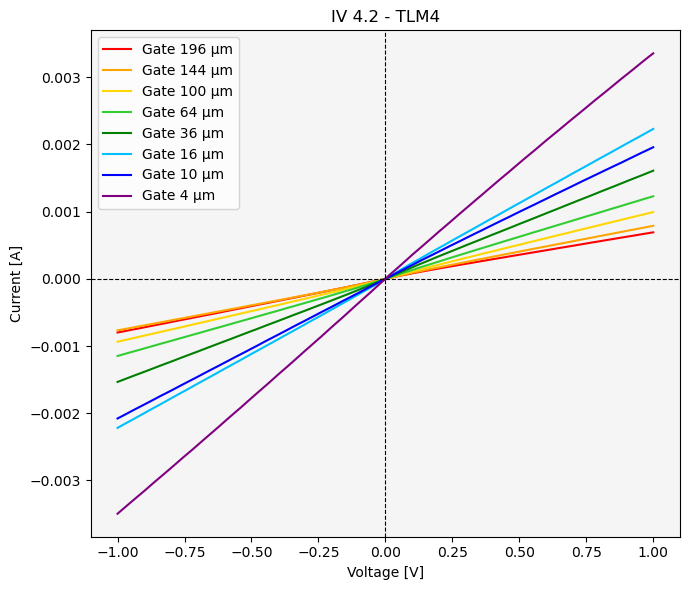

Measurment2txt_TLM4: slope = 0.000754621 A/V,  R = 1325.17 Ω, Measurment3txt_TLM4: slope = 0.000787959 A/V,  R = 1269.1 Ω, Measurment4txt_TLM4: slope = 0.000975265 A/V,  R = 1025.36 Ω, Measurment5txt_TLM4: slope = 0.00119875 A/V,  R = 834.204 Ω, Measurment6txt_TLM4: slope = 0.00158124 A/V,  R = 632.417 Ω, Measurment7txt_TLM4: slope = 0.00223366 A/V,  R = 447.695 Ω, Measurmenttxt_TLM4: slope = 0.00202567 A/V,  R = 493.665 Ω, Measurment8txt_TLM4: slope = 0.00345999 A/V,  R = 289.018 Ω, 
=== 4.3 | TLM1 ===


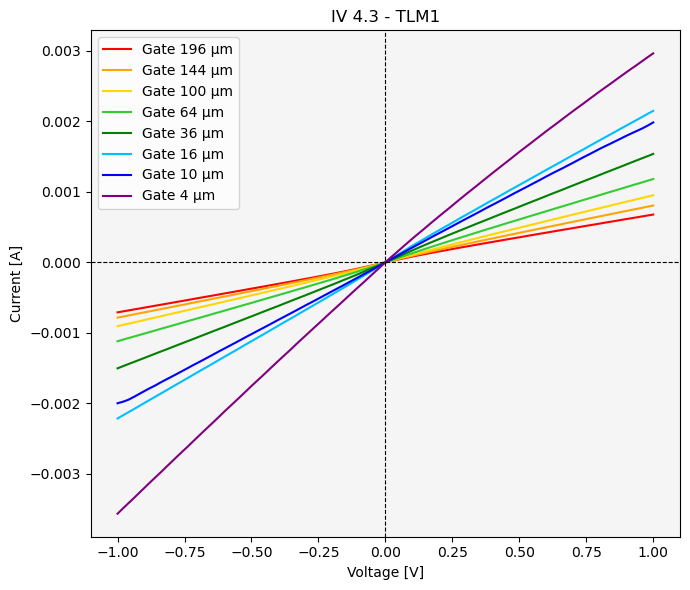

Measurment2txt_TLM1: slope = 0.000709745 A/V,  R = 1408.96 Ω, Measurment3txt_TLM1: slope = 0.000809543 A/V,  R = 1235.26 Ω, Measurment4txt_TLM1: slope = 0.000942709 A/V,  R = 1060.77 Ω, Measurment5txt_TLM1: slope = 0.00116528 A/V,  R = 858.165 Ω, Measurment6txt_TLM1: slope = 0.00153629 A/V,  R = 650.917 Ω, Measurment7txt_TLM1: slope = 0.0021977 A/V,  R = 455.021 Ω, Measurmenttxt_TLM1: slope = 0.00201968 A/V,  R = 495.128 Ω, Measurment8txt_TLM1: slope = 0.00329164 A/V,  R = 303.8 Ω, 
=== 4.3 | TLM2 ===


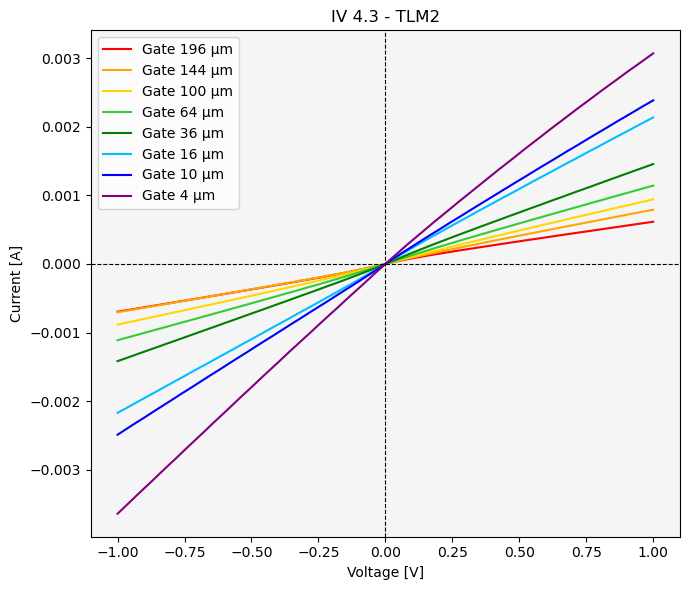

Measurment2txt_TLM2: slope = 0.000676293 A/V,  R = 1478.65 Ω, Measurment3txt_TLM2: slope = 0.000762897 A/V,  R = 1310.79 Ω, Measurment4txt_TLM2: slope = 0.000929421 A/V,  R = 1075.94 Ω, Measurment5txt_TLM2: slope = 0.00114381 A/V,  R = 874.27 Ω, Measurment6txt_TLM2: slope = 0.00145322 A/V,  R = 688.126 Ω, Measurment7txt_TLM2: slope = 0.00217031 A/V,  R = 460.764 Ω, Measurmenttxt_TLM2: slope = 0.00244949 A/V,  R = 408.248 Ω, Measurment8txt_TLM2: slope = 0.00338042 A/V,  R = 295.822 Ω, 
=== 4.3 | TLM3 ===


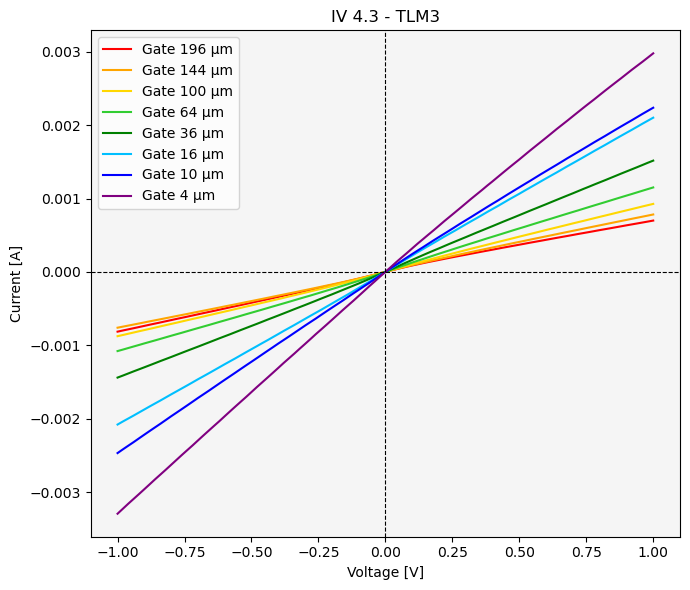

Measurment2txt_TLM3: slope = 0.000772424 A/V,  R = 1294.63 Ω, Measurment3txt_TLM3: slope = 0.000787617 A/V,  R = 1269.65 Ω, Measurment4txt_TLM3: slope = 0.000917412 A/V,  R = 1090.02 Ω, Measurment5txt_TLM3: slope = 0.00113015 A/V,  R = 884.84 Ω, Measurment6txt_TLM3: slope = 0.00149285 A/V,  R = 669.858 Ω, Measurment7txt_TLM3: slope = 0.00210399 A/V,  R = 475.287 Ω, Measurmenttxt_TLM3: slope = 0.00236441 A/V,  R = 422.939 Ω, Measurment8txt_TLM3: slope = 0.00315317 A/V,  R = 317.142 Ω, 
=== 4.3 | TLM4 ===


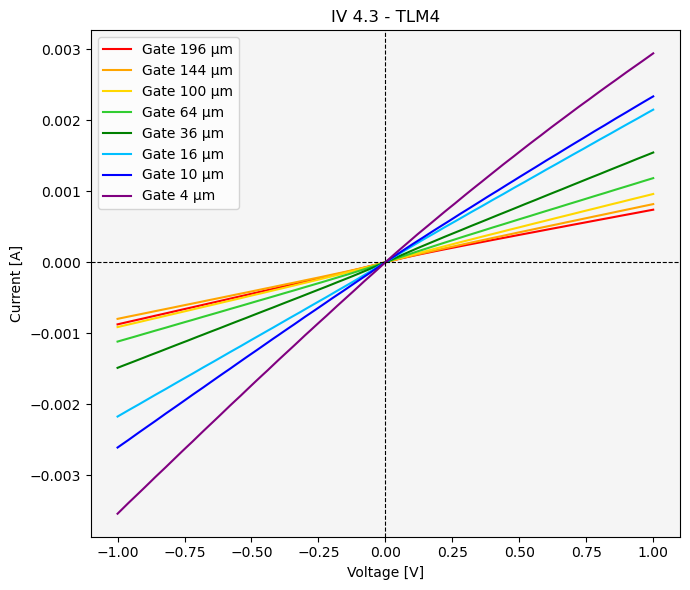

Measurment2txt_TLM4: slope = 0.000818404 A/V,  R = 1221.89 Ω, Measurment3txt_TLM4: slope = 0.000820149 A/V,  R = 1219.29 Ω, Measurment4txt_TLM4: slope = 0.000949454 A/V,  R = 1053.24 Ω, Measurment5txt_TLM4: slope = 0.0011635 A/V,  R = 859.473 Ω, Measurment6txt_TLM4: slope = 0.00152897 A/V,  R = 654.033 Ω, Measurment7txt_TLM4: slope = 0.00217334 A/V,  R = 460.122 Ω, Measurmenttxt_TLM4: slope = 0.002483 A/V,  R = 402.738 Ω, Measurment8txt_TLM4: slope = 0.00326696 A/V,  R = 306.095 Ω, 
=== 4.4 | TLM1 ===


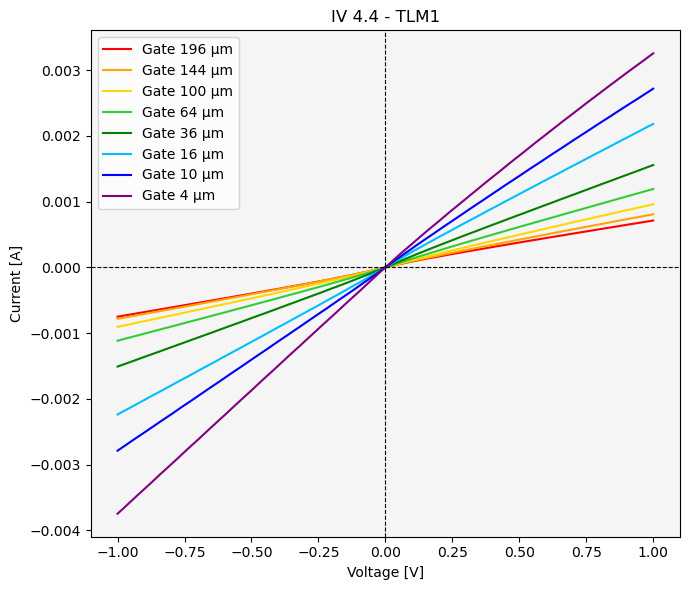

Measurment2txt_TLM1: slope = 0.000752409 A/V,  R = 1329.07 Ω, Measurment3txt_TLM1: slope = 0.000812061 A/V,  R = 1231.43 Ω, Measurment4txt_TLM1: slope = 0.000948908 A/V,  R = 1053.84 Ω, Measurment5txt_TLM1: slope = 0.00117131 A/V,  R = 853.747 Ω, Measurment6txt_TLM1: slope = 0.00155085 A/V,  R = 644.806 Ω, Measurment7txt_TLM1: slope = 0.00222838 A/V,  R = 448.756 Ω, Measurmenttxt_TLM1: slope = 0.00277362 A/V,  R = 360.54 Ω, Measurment8txt_TLM1: slope = 0.00353613 A/V,  R = 282.795 Ω, 
=== 4.4 | TLM2 ===


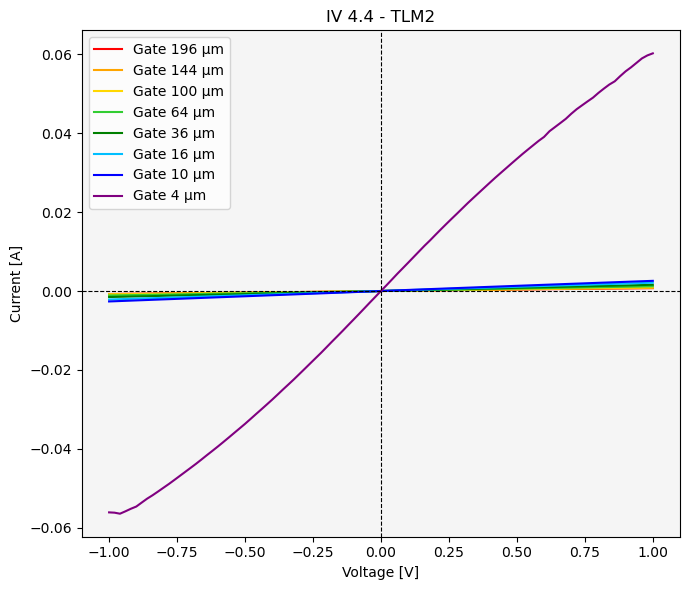

Measurment2txt_TLM2: slope = 0.000761582 A/V,  R = 1313.06 Ω, Measurment3txt_TLM2: slope = 0.000809963 A/V,  R = 1234.62 Ω, Measurment4txt_TLM2: slope = 0.000943056 A/V,  R = 1060.38 Ω, Measurment5txt_TLM2: slope = 0.0011796 A/V,  R = 847.743 Ω, Measurment6txt_TLM2: slope = 0.00156907 A/V,  R = 637.321 Ω, Measurment7txt_TLM2: slope = 0.00214402 A/V,  R = 466.413 Ω, Measurmenttxt_TLM2: slope = 0.00262869 A/V,  R = 380.418 Ω, Measurment8txt_TLM2: slope = 0.0631107 A/V,  R = 15.8452 Ω, 
=== 4.4 | TLM3 ===


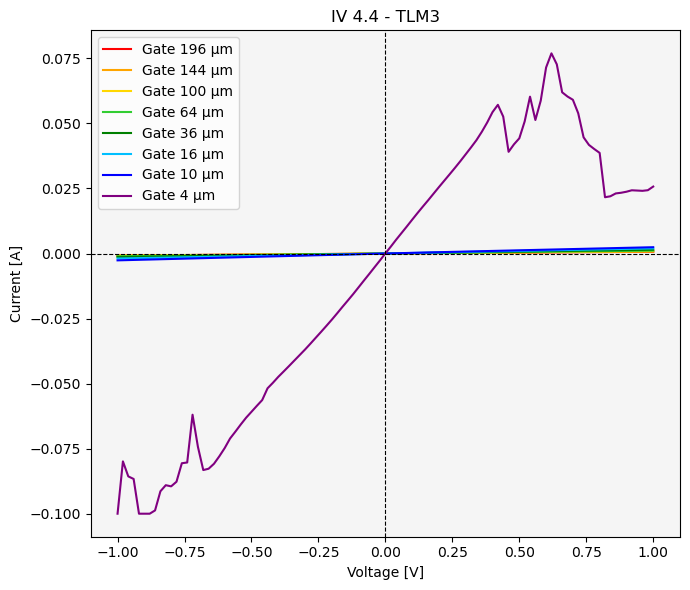

Measurment2txt_TLM3: slope = 0.000727963 A/V,  R = 1373.7 Ω, Measurment3txt_TLM3: slope = 0.000789592 A/V,  R = 1266.48 Ω, Measurment4txt_TLM3: slope = 0.00090911 A/V,  R = 1099.98 Ω, Measurment5txt_TLM3: slope = 0.00109516 A/V,  R = 913.109 Ω, Measurment6txt_TLM3: slope = 0.00143512 A/V,  R = 696.805 Ω, Measurment7txt_TLM3: slope = 0.00196056 A/V,  R = 510.058 Ω, Measurmenttxt_TLM3: slope = 0.00253462 A/V,  R = 394.536 Ω, Measurment8txt_TLM3: slope = 0.0843486 A/V,  R = 11.8556 Ω, 
=== 4.4 | TLM4 ===


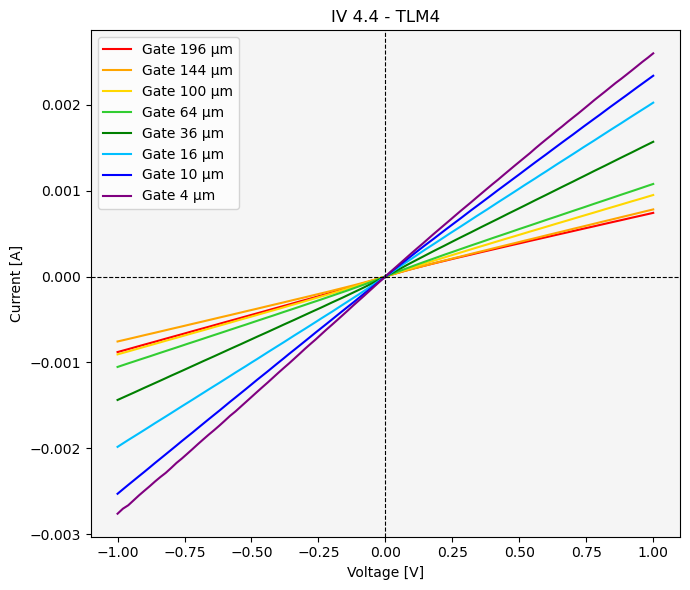

Measurment2txt_TLM4: slope = 0.000820046 A/V,  R = 1219.44 Ω, Measurment3txt_TLM4: slope = 0.000778762 A/V,  R = 1284.09 Ω, Measurment4txt_TLM4: slope = 0.000937955 A/V,  R = 1066.15 Ω, Measurment5txt_TLM4: slope = 0.00107564 A/V,  R = 929.677 Ω, Measurment6txt_TLM4: slope = 0.0015125 A/V,  R = 661.155 Ω, Measurment7txt_TLM4: slope = 0.00201172 A/V,  R = 497.086 Ω, Measurmenttxt_TLM4: slope = 0.00243789 A/V,  R = 410.191 Ω, Measurment8txt_TLM4: slope = 0.00270685 A/V,  R = 369.433 Ω, 
=== 5.1 | TLM1 ===


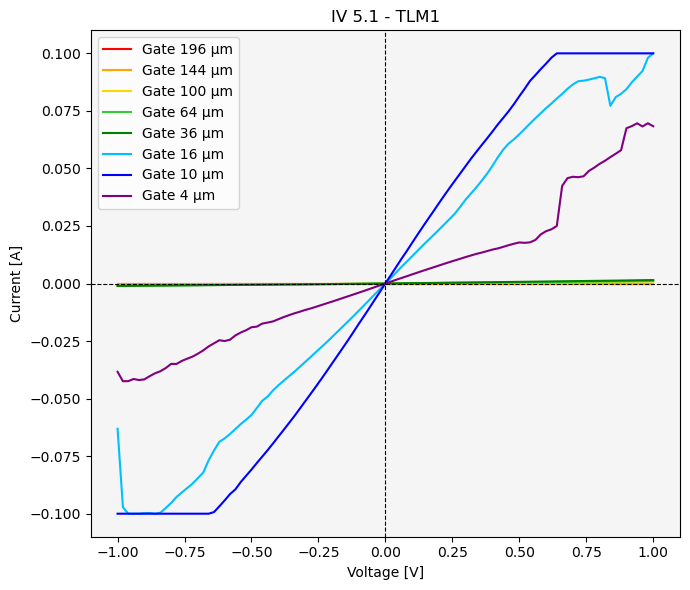

Measurment2txt_TLM1: slope = 2.26718e-09 A/V,  R = 4.41076e+08 Ω, Measurment3txt_TLM1: slope = 2.22551e-09 A/V,  R = 4.49336e+08 Ω, Measurment4txt_TLM1: slope = 0.000887423 A/V,  R = 1126.86 Ω, Measurment5txt_TLM1: slope = 0.00103503 A/V,  R = 966.16 Ω, Measurment6txt_TLM1: slope = 0.00127732 A/V,  R = 782.891 Ω, Measurment7txt_TLM1: slope = 0.110393 A/V,  R = 9.05851 Ω, Measurmenttxt_TLM1: slope = 0.130363 A/V,  R = 7.6709 Ω, Measurment8txt_TLM1: slope = 0.051268 A/V,  R = 19.5053 Ω, 
=== 5.1 | TLM2 ===


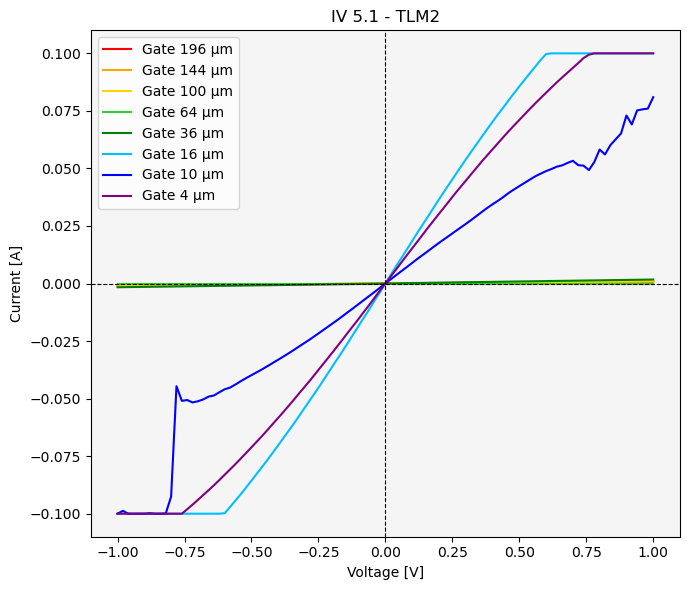

Measurment2txt_TLM2: slope = 0.000821116 A/V,  R = 1217.85 Ω, Measurment3txt_TLM2: slope = 0.000865453 A/V,  R = 1155.46 Ω, Measurment4txt_TLM2: slope = 0.00101865 A/V,  R = 981.691 Ω, Measurment5txt_TLM2: slope = 2.05284e-09 A/V,  R = 4.87129e+08 Ω, Measurment6txt_TLM2: slope = 0.00169801 A/V,  R = 588.926 Ω, Measurment7txt_TLM2: slope = 0.132401 A/V,  R = 7.5528 Ω, Measurmenttxt_TLM2: slope = 0.0852125 A/V,  R = 11.7354 Ω, Measurment8txt_TLM2: slope = 0.123717 A/V,  R = 8.08294 Ω, 
=== 5.1 | TLM3 ===


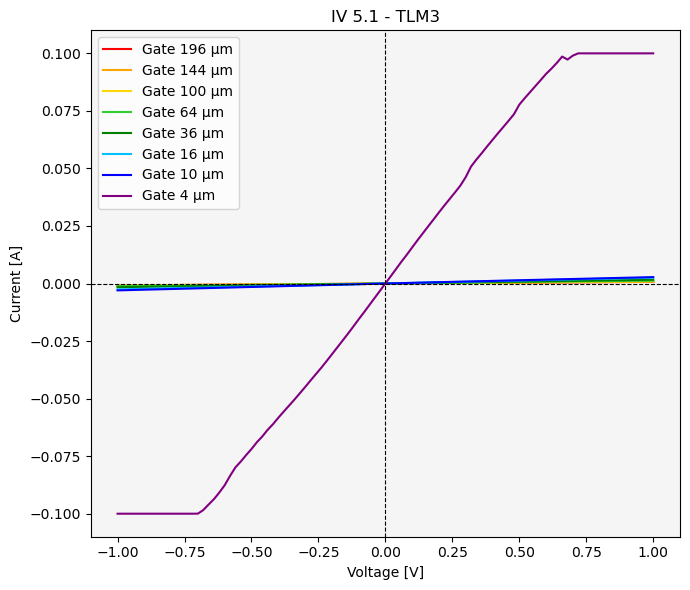

Measurment2txt_TLM3: slope = 0.000792534 A/V,  R = 1261.78 Ω, Measurment3txt_TLM3: slope = 0.000789051 A/V,  R = 1267.35 Ω, Measurment4txt_TLM3: slope = 0.000971719 A/V,  R = 1029.1 Ω, Measurment5txt_TLM3: slope = 0.00121556 A/V,  R = 822.665 Ω, Measurment6txt_TLM3: slope = 0.00165172 A/V,  R = 605.429 Ω, Measurment7txt_TLM3: slope = 0.00256073 A/V,  R = 390.514 Ω, Measurmenttxt_TLM3: slope = 0.00289426 A/V,  R = 345.511 Ω, Measurment8txt_TLM3: slope = 0.126708 A/V,  R = 7.89213 Ω, 
=== 5.1 | TLM4 ===


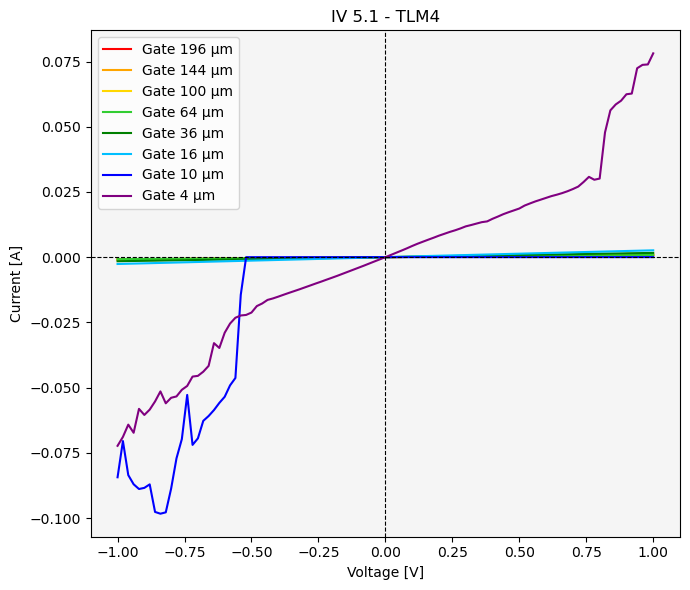

Measurment2txt_TLM4: slope = 0.000836643 A/V,  R = 1195.25 Ω, Measurment3txt_TLM4: slope = 0.000859506 A/V,  R = 1163.46 Ω, Measurment4txt_TLM4: slope = 0.00100322 A/V,  R = 996.792 Ω, Measurment5txt_TLM4: slope = 0.000804503 A/V,  R = 1243 Ω, Measurment6txt_TLM4: slope = 0.00161175 A/V,  R = 620.445 Ω, Measurment7txt_TLM4: slope = 0.00264109 A/V,  R = 378.632 Ω, Measurmenttxt_TLM4: slope = 0.0400056 A/V,  R = 24.9965 Ω, Measurment8txt_TLM4: slope = 0.0573671 A/V,  R = 17.4316 Ω, 
=== 5.2 | TLM1 ===


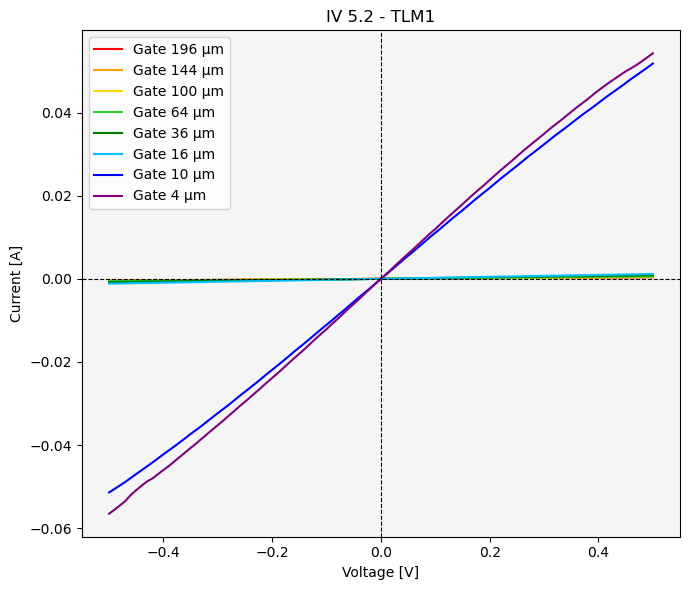

Measurment2txt_TLM1: slope = 0.000809828 A/V,  R = 1234.83 Ω, Measurment3txt_TLM1: slope = 0.000832484 A/V,  R = 1201.22 Ω, Measurment4txt_TLM1: slope = 0.000961121 A/V,  R = 1040.45 Ω, Measurment5txt_TLM1: slope = 0.00115594 A/V,  R = 865.096 Ω, Measurment6txt_TLM1: slope = 0.00164463 A/V,  R = 608.038 Ω, Measurment7txt_TLM1: slope = 0.00234789 A/V,  R = 425.914 Ω, Measurmenttxt_TLM1: slope = 0.105999 A/V,  R = 9.43409 Ω, Measurment8txt_TLM1: slope = 0.114315 A/V,  R = 8.74777 Ω, 
=== 5.2 | TLM2 ===


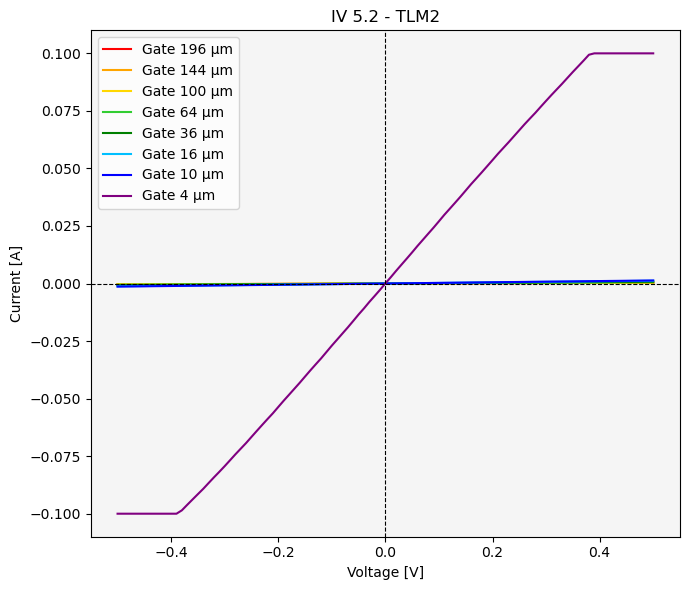

Measurment2txt_TLM2: slope = 0.0007089 A/V,  R = 1410.64 Ω, Measurment3txt_TLM2: slope = 0.000687528 A/V,  R = 1454.49 Ω, Measurment4txt_TLM2: slope = 0.000828351 A/V,  R = 1207.22 Ω, Measurment5txt_TLM2: slope = 0.00114499 A/V,  R = 873.368 Ω, Measurment6txt_TLM2: slope = 0.00154184 A/V,  R = 648.574 Ω, Measurment7txt_TLM2: slope = 0.00244413 A/V,  R = 409.144 Ω, Measurmenttxt_TLM2: slope = 0.00268154 A/V,  R = 372.92 Ω, Measurment8txt_TLM2: slope = 0.241587 A/V,  R = 4.13929 Ω, 
=== 5.2 | TLM3 ===


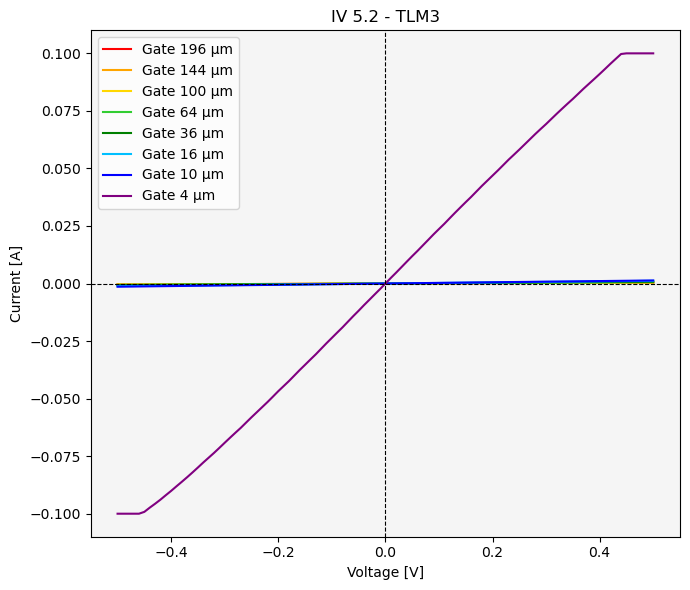

Measurment2txt_TLM3: slope = 0.000837172 A/V,  R = 1194.5 Ω, Measurment3txt_TLM3: slope = 0.000852505 A/V,  R = 1173.01 Ω, Measurment4txt_TLM3: slope = 0.000984633 A/V,  R = 1015.61 Ω, Measurment5txt_TLM3: slope = 0.00121649 A/V,  R = 822.036 Ω, Measurment6txt_TLM3: slope = 0.00153829 A/V,  R = 650.074 Ω, Measurment7txt_TLM3: slope = 0.00234542 A/V,  R = 426.362 Ω, Measurmenttxt_TLM3: slope = 0.00271761 A/V,  R = 367.971 Ω, Measurment8txt_TLM3: slope = 0.22312 A/V,  R = 4.4819 Ω, 
=== 5.2 | TLM4 ===


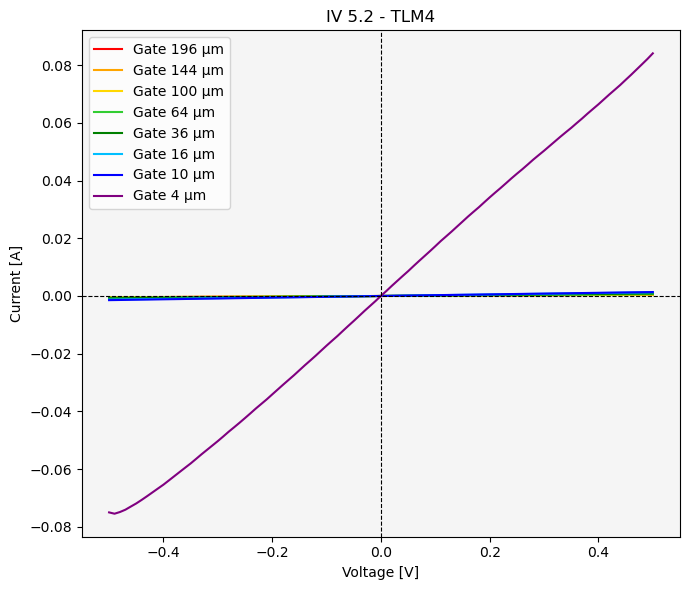

Measurment2txt_TLM4: slope = 0.000868733 A/V,  R = 1151.1 Ω, Measurment3txt_TLM4: slope = 0.000868844 A/V,  R = 1150.95 Ω, Measurment4txt_TLM4: slope = 0.00100894 A/V,  R = 991.14 Ω, Measurment5txt_TLM4: slope = 0.0012569 A/V,  R = 795.61 Ω, Measurment6txt_TLM4: slope = 0.00169532 A/V,  R = 589.858 Ω, Measurment7txt_TLM4: slope = 0.00252265 A/V,  R = 396.409 Ω, Measurmenttxt_TLM4: slope = 0.00281667 A/V,  R = 355.03 Ω, Measurment8txt_TLM4: slope = 0.164932 A/V,  R = 6.06309 Ω, 
=== 5.3 | TLM1 ===


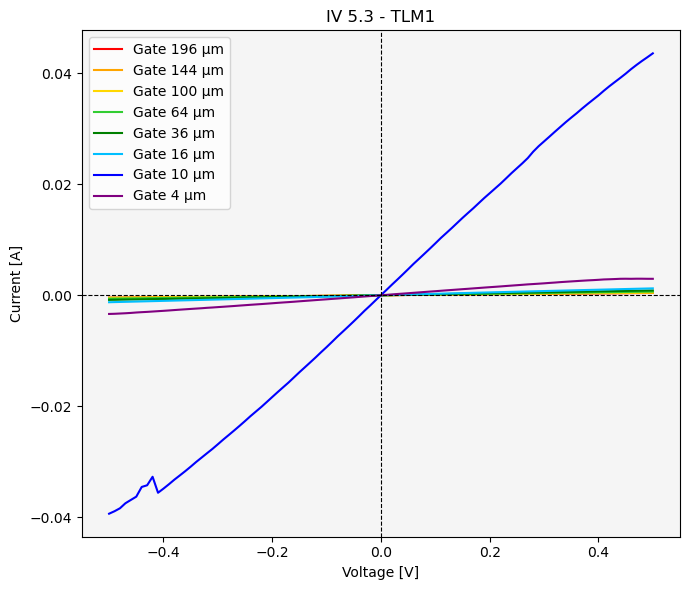

Measurment2txt_TLM1: slope = 0.000889879 A/V,  R = 1123.75 Ω, Measurment3txt_TLM1: slope = 0.000890905 A/V,  R = 1122.45 Ω, Measurment4txt_TLM1: slope = 0.00101859 A/V,  R = 981.752 Ω, Measurment5txt_TLM1: slope = 0.00129336 A/V,  R = 773.179 Ω, Measurment6txt_TLM1: slope = 0.00172474 A/V,  R = 579.798 Ω, Measurment7txt_TLM1: slope = 0.00252523 A/V,  R = 396.004 Ω, Measurmenttxt_TLM1: slope = 0.0874913 A/V,  R = 11.4297 Ω, Measurment8txt_TLM1: slope = 0.00691119 A/V,  R = 144.693 Ω, 
=== 5.3 | TLM2 ===


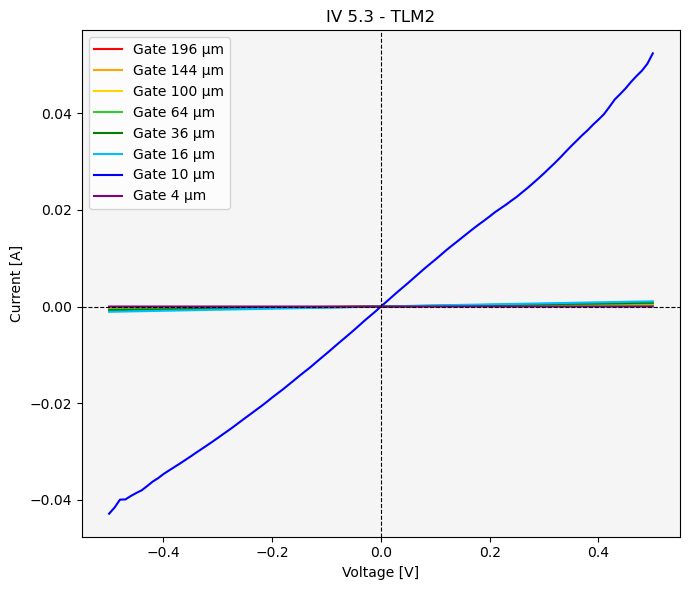

Measurment2txt_TLM2: slope = 0.00079808 A/V,  R = 1253.01 Ω, Measurment3txt_TLM2: slope = 0.000806944 A/V,  R = 1239.24 Ω, Measurment4txt_TLM2: slope = 0.00100612 A/V,  R = 993.916 Ω, Measurment5txt_TLM2: slope = 0.00120582 A/V,  R = 829.311 Ω, Measurment6txt_TLM2: slope = 0.00157075 A/V,  R = 636.639 Ω, Measurment7txt_TLM2: slope = 0.00219349 A/V,  R = 455.894 Ω, Measurmenttxt_TLM2: slope = 0.0927144 A/V,  R = 10.7858 Ω, Measurment8txt_TLM2: slope = 4.68495e-07 A/V,  R = 2.1345e+06 Ω, 
=== 5.3 | TLM3 ===


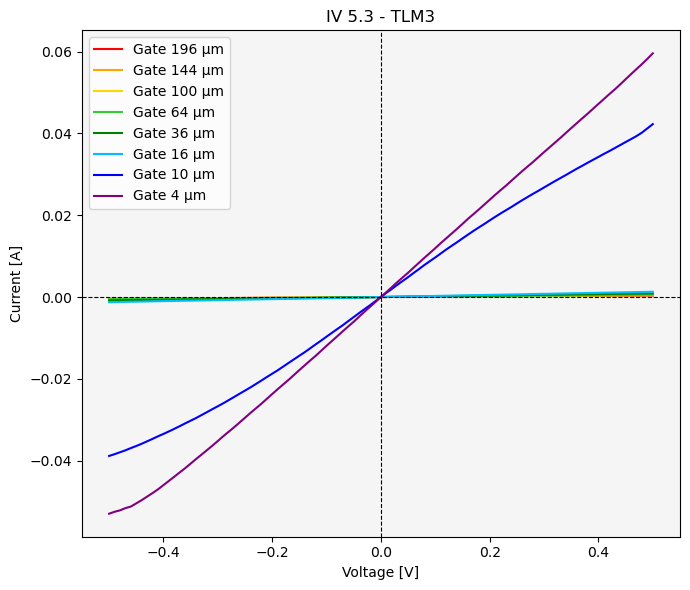

Measurment2txt_TLM3: slope = 0.000811318 A/V,  R = 1232.56 Ω, Measurment3txt_TLM3: slope = 0.0008418 A/V,  R = 1187.93 Ω, Measurment4txt_TLM3: slope = 0.000980931 A/V,  R = 1019.44 Ω, Measurment5txt_TLM3: slope = 0.00110211 A/V,  R = 907.349 Ω, Measurment6txt_TLM3: slope = 0.00173488 A/V,  R = 576.408 Ω, Measurment7txt_TLM3: slope = 0.0025549 A/V,  R = 391.405 Ω, Measurmenttxt_TLM3: slope = 0.0857347 A/V,  R = 11.6639 Ω, Measurment8txt_TLM3: slope = 0.116129 A/V,  R = 8.61109 Ω, 
=== 5.3 | TLM4 ===


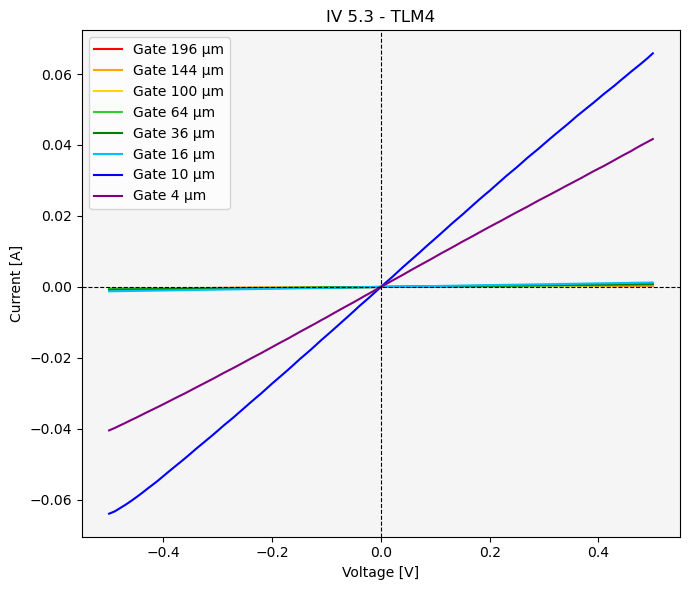

Measurment2txt_TLM4: slope = 0.000886726 A/V,  R = 1127.74 Ω, Measurment3txt_TLM4: slope = 0.000885502 A/V,  R = 1129.3 Ω, Measurment4txt_TLM4: slope = 0.00103266 A/V,  R = 968.369 Ω, Measurment5txt_TLM4: slope = 0.00126934 A/V,  R = 787.811 Ω, Measurment6txt_TLM4: slope = 0.00162658 A/V,  R = 614.788 Ω, Measurment7txt_TLM4: slope = 0.00249773 A/V,  R = 400.364 Ω, Measurmenttxt_TLM4: slope = 0.132975 A/V,  R = 7.52022 Ω, Measurment8txt_TLM4: slope = 0.0831304 A/V,  R = 12.0293 Ω, 
=== 5.4 | TLM1 ===


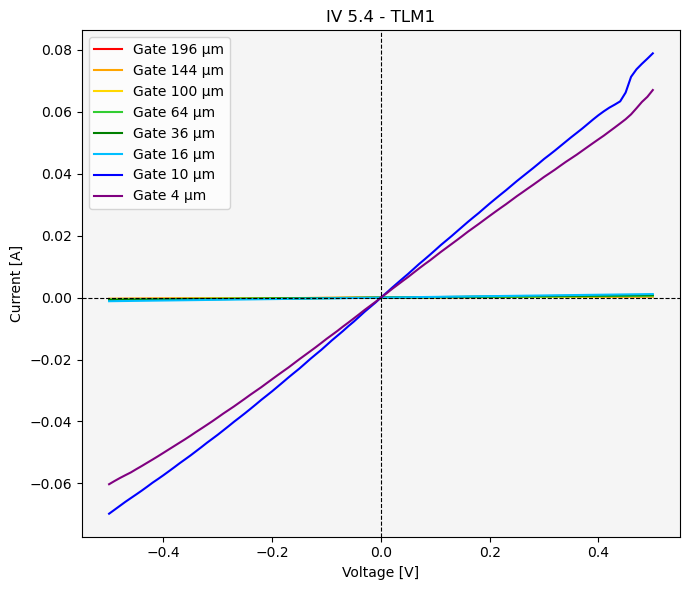

Measurment2txt_TLM1: slope = 0.000851586 A/V,  R = 1174.28 Ω, Measurment3txt_TLM1: slope = 0.000850734 A/V,  R = 1175.46 Ω, Measurment4txt_TLM1: slope = 0.000858556 A/V,  R = 1164.75 Ω, Measurment5txt_TLM1: slope = 0.00120772 A/V,  R = 828.008 Ω, Measurment6txt_TLM1: slope = 0.00163108 A/V,  R = 613.09 Ω, Measurment7txt_TLM1: slope = 0.00232898 A/V,  R = 429.372 Ω, Measurmenttxt_TLM1: slope = 0.147323 A/V,  R = 6.78779 Ω, Measurment8txt_TLM1: slope = 0.127734 A/V,  R = 7.82877 Ω, 
=== 5.4 | TLM2 ===


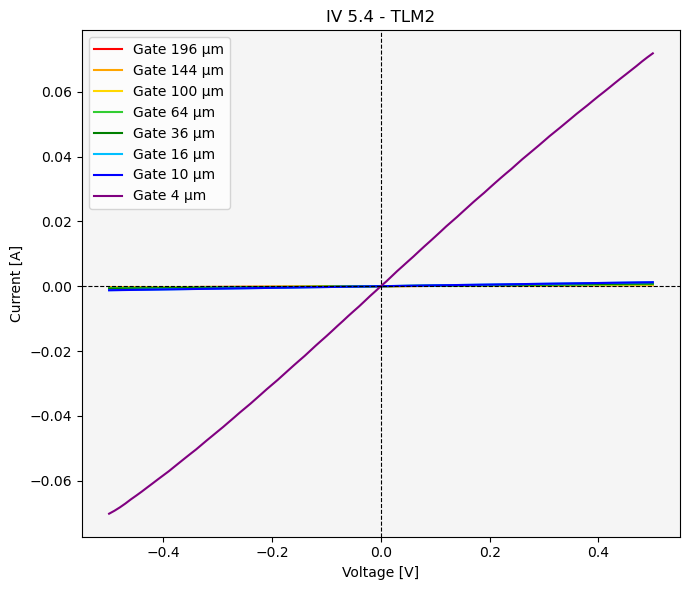

Measurment2txt_TLM2: slope = 0.000682301 A/V,  R = 1465.63 Ω, Measurment3txt_TLM2: slope = 0.000752661 A/V,  R = 1328.62 Ω, Measurment4txt_TLM2: slope = 0.00094351 A/V,  R = 1059.87 Ω, Measurment5txt_TLM2: slope = 0.00123526 A/V,  R = 809.546 Ω, Measurment6txt_TLM2: slope = 0.00165683 A/V,  R = 603.563 Ω, Measurment7txt_TLM2: slope = 0.00246114 A/V,  R = 406.316 Ω, Measurmenttxt_TLM2: slope = 0.00249404 A/V,  R = 400.957 Ω, Measurment8txt_TLM2: slope = 0.146574 A/V,  R = 6.8225 Ω, 
=== 5.4 | TLM3 ===


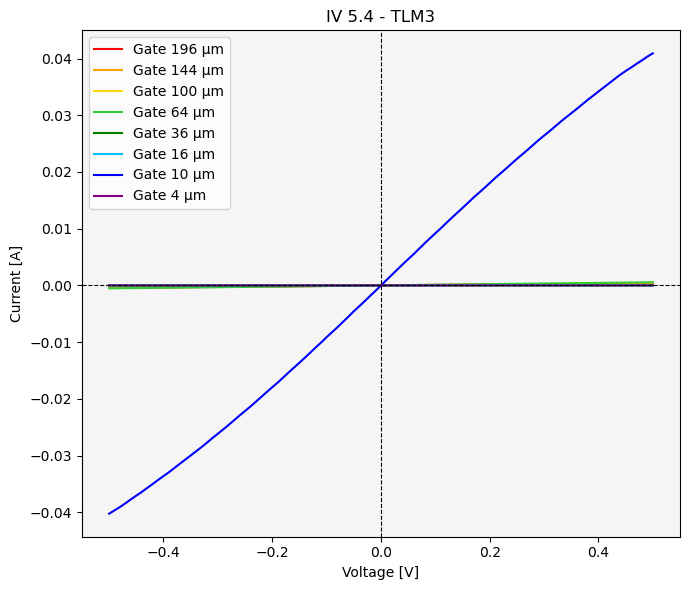

Measurment2txt_TLM3: slope = 0.000811811 A/V,  R = 1231.81 Ω, Measurment3txt_TLM3: slope = 0.000825679 A/V,  R = 1211.12 Ω, Measurment4txt_TLM3: slope = 1.189e-05 A/V,  R = 84104.2 Ω, Measurment5txt_TLM3: slope = 0.00107799 A/V,  R = 927.654 Ω, Measurment6txt_TLM3: slope = 8.23983e-06 A/V,  R = 121362 Ω, Measurment7txt_TLM3: slope = 4.04219e-06 A/V,  R = 247390 Ω, Measurmenttxt_TLM3: slope = 0.0851337 A/V,  R = 11.7462 Ω, Measurment8txt_TLM3: slope = 8.43499e-06 A/V,  R = 118554 Ω, 
=== 5.4 | TLM4 ===


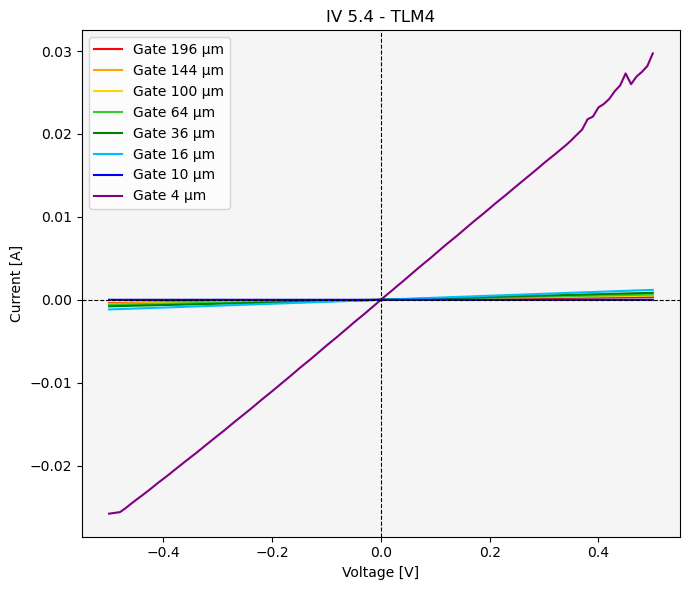

Measurment2txt_TLM4: slope = 0.000740046 A/V,  R = 1351.27 Ω, Measurment3txt_TLM4: slope = 5.94243e-13 A/V,  R = 1.68281e+12 Ω, Measurment4txt_TLM4: slope = 0.000990677 A/V,  R = 1009.41 Ω, Measurment5txt_TLM4: slope = 0.00123632 A/V,  R = 808.852 Ω, Measurment6txt_TLM4: slope = 0.0016505 A/V,  R = 605.876 Ω, Measurment7txt_TLM4: slope = 0.00237989 A/V,  R = 420.188 Ω, Measurmenttxt_TLM4: slope = 4.11509e-06 A/V,  R = 243008 Ω, Measurment8txt_TLM4: slope = 0.0553541 A/V,  R = 18.0655 Ω, 
=== 6.1 | TLM1 ===


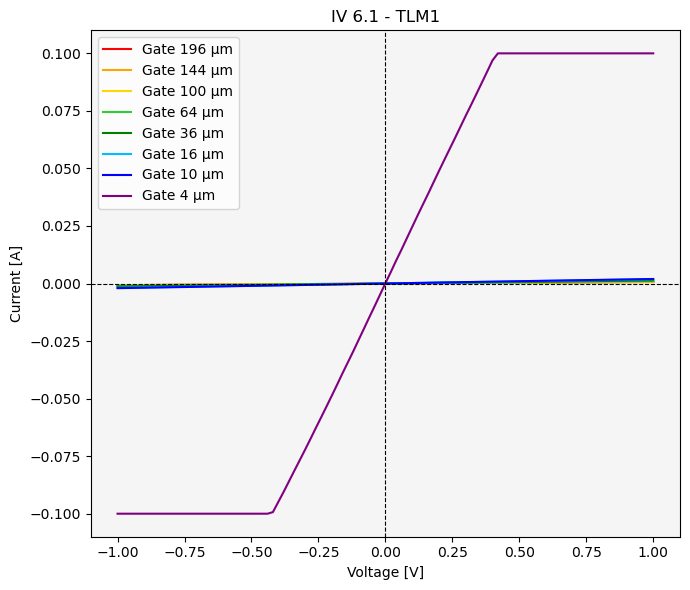

Measurment2txt_TLM1: slope = 0.000703381 A/V,  R = 1421.7 Ω, Measurment3txt_TLM1: slope = 0.000744896 A/V,  R = 1342.47 Ω, Measurment4txt_TLM1: slope = 0.000861712 A/V,  R = 1160.48 Ω, Measurment5txt_TLM1: slope = 0.00105174 A/V,  R = 950.808 Ω, Measurment6txt_TLM1: slope = 0.00135027 A/V,  R = 740.594 Ω, Measurment7txt_TLM1: slope = 0.00189499 A/V,  R = 527.707 Ω, Measurmenttxt_TLM1: slope = 0.0020083 A/V,  R = 497.934 Ω, Measurment8txt_TLM1: slope = 0.140198 A/V,  R = 7.13278 Ω, 
=== 6.1 | TLM2 ===


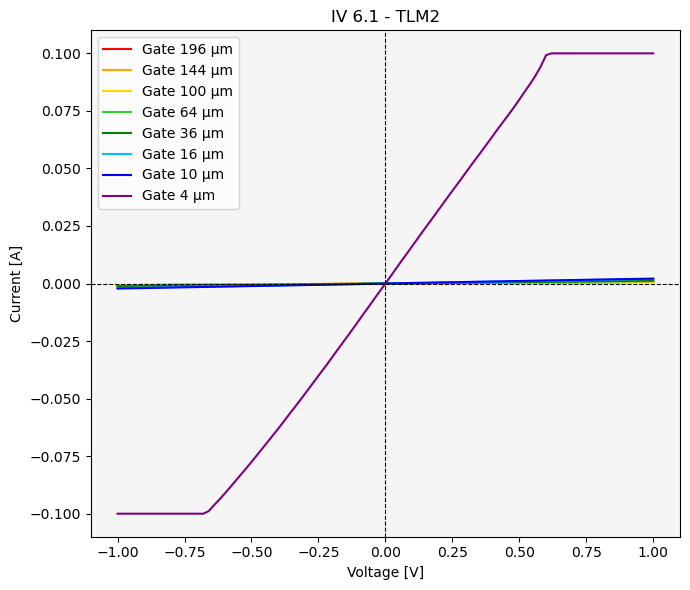

Measurment2txt_TLM2: slope = 0.000700687 A/V,  R = 1427.17 Ω, Measurment3txt_TLM2: slope = 0.000732713 A/V,  R = 1364.79 Ω, Measurment4txt_TLM2: slope = 0.000806865 A/V,  R = 1239.36 Ω, Measurment5txt_TLM2: slope = 0.00102988 A/V,  R = 970.99 Ω, Measurment6txt_TLM2: slope = 0.00125565 A/V,  R = 796.401 Ω, Measurment7txt_TLM2: slope = 0.0019948 A/V,  R = 501.302 Ω, Measurmenttxt_TLM2: slope = 0.00217493 A/V,  R = 459.785 Ω, Measurment8txt_TLM2: slope = 0.129035 A/V,  R = 7.74981 Ω, 
=== 6.1 | TLM3 ===


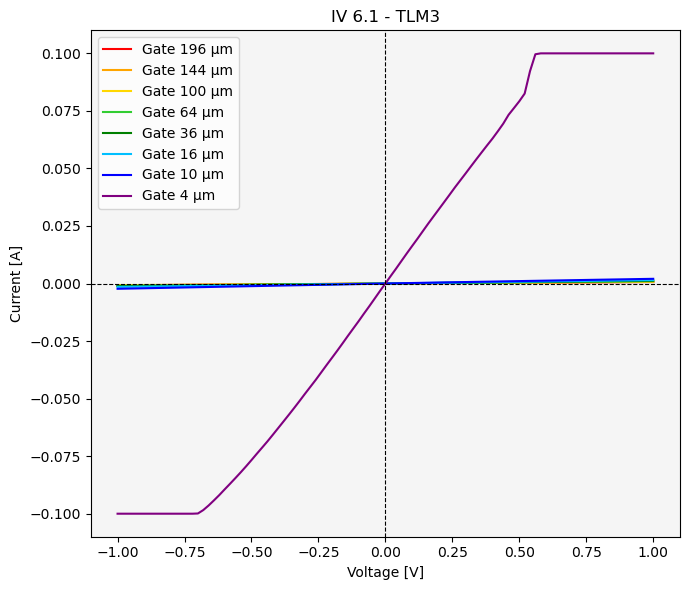

Measurment2txt_TLM3: slope = 0.000724911 A/V,  R = 1379.48 Ω, Measurment3txt_TLM3: slope = 0.000734995 A/V,  R = 1360.55 Ω, Measurment4txt_TLM3: slope = 0.000847472 A/V,  R = 1179.98 Ω, Measurment5txt_TLM3: slope = 0.00103802 A/V,  R = 963.369 Ω, Measurment6txt_TLM3: slope = 0.00117712 A/V,  R = 849.535 Ω, Measurment7txt_TLM3: slope = 0.00149161 A/V,  R = 670.418 Ω, Measurmenttxt_TLM3: slope = 0.00217817 A/V,  R = 459.101 Ω, Measurment8txt_TLM3: slope = 0.129003 A/V,  R = 7.75178 Ω, 
=== 6.1 | TLM4 ===


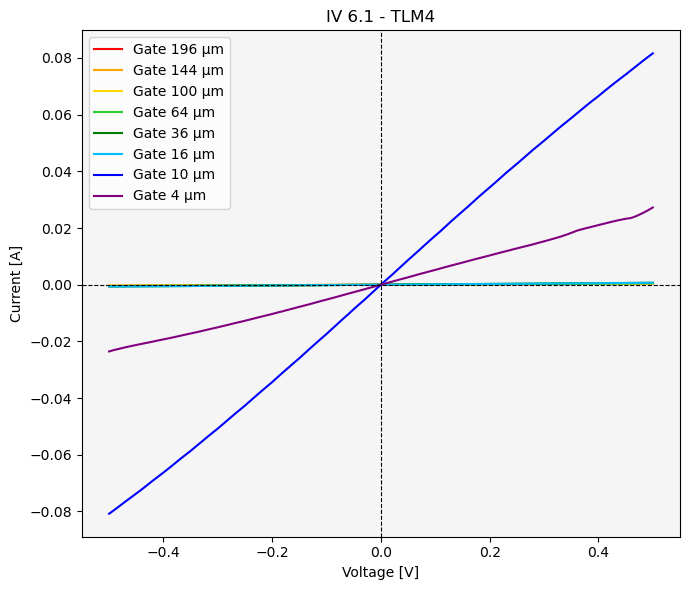

Measurment2txt_TLM4: slope = 0.000782828 A/V,  R = 1277.42 Ω, Measurment3txt_TLM4: slope = 0.000681378 A/V,  R = 1467.61 Ω, Measurment4txt_TLM4: slope = 0.000813187 A/V,  R = 1229.73 Ω, Measurment5txt_TLM4: slope = 0.00102196 A/V,  R = 978.513 Ω, Measurment6txt_TLM4: slope = 0.00134312 A/V,  R = 744.533 Ω, Measurment7txt_TLM4: slope = 0.00132321 A/V,  R = 755.736 Ω, Measurmenttxt_TLM4: slope = 0.166487 A/V,  R = 6.00648 Ω, Measurment8txt_TLM4: slope = 0.0503842 A/V,  R = 19.8475 Ω, 
=== 6.2 | TLM1 ===


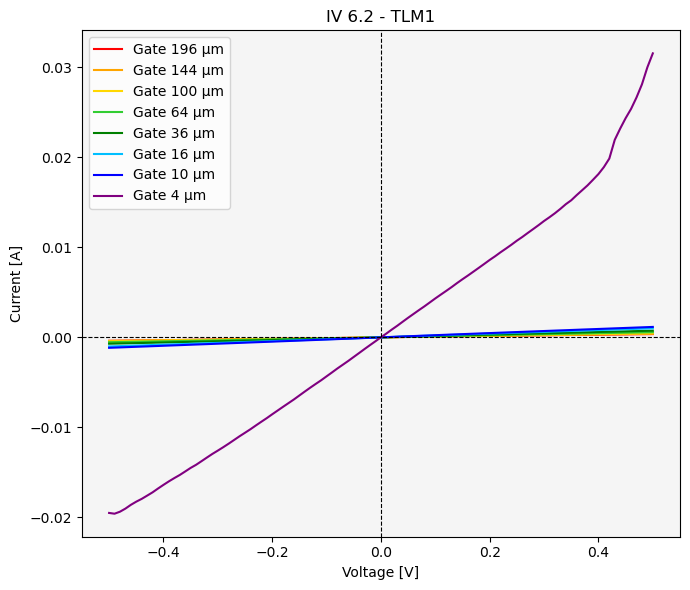

Measurment2txt_TLM1: slope = 0.000769705 A/V,  R = 1299.2 Ω, Measurment3txt_TLM1: slope = 0.000806095 A/V,  R = 1240.55 Ω, Measurment4txt_TLM1: slope = 0.000925171 A/V,  R = 1080.88 Ω, Measurment5txt_TLM1: slope = 0.00112935 A/V,  R = 885.466 Ω, Measurment6txt_TLM1: slope = 0.00146588 A/V,  R = 682.185 Ω, Measurment7txt_TLM1: slope = 0.00203607 A/V,  R = 491.143 Ω, Measurmenttxt_TLM1: slope = 0.00233758 A/V,  R = 427.792 Ω, Measurment8txt_TLM1: slope = 0.0451634 A/V,  R = 22.1418 Ω, 
=== 6.2 | TLM2 ===


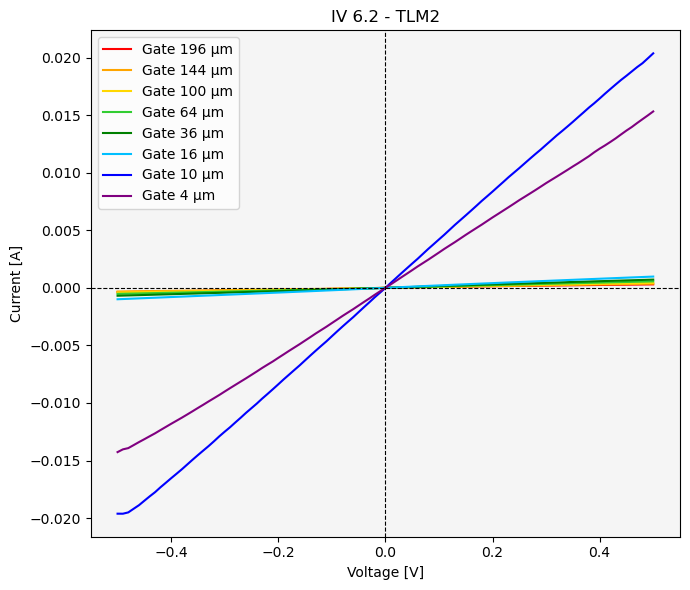

Measurment2txt_TLM2: slope = 0.000700619 A/V,  R = 1427.31 Ω, Measurment3txt_TLM2: slope = 0.000696514 A/V,  R = 1435.72 Ω, Measurment4txt_TLM2: slope = 0.000863829 A/V,  R = 1157.64 Ω, Measurment5txt_TLM2: slope = 0.00110701 A/V,  R = 903.337 Ω, Measurment6txt_TLM2: slope = 0.00142239 A/V,  R = 703.043 Ω, Measurment7txt_TLM2: slope = 0.00199828 A/V,  R = 500.431 Ω, Measurmenttxt_TLM2: slope = 0.0411785 A/V,  R = 24.2845 Ω, Measurment8txt_TLM2: slope = 0.0299407 A/V,  R = 33.3993 Ω, 
=== 6.2 | TLM3 ===


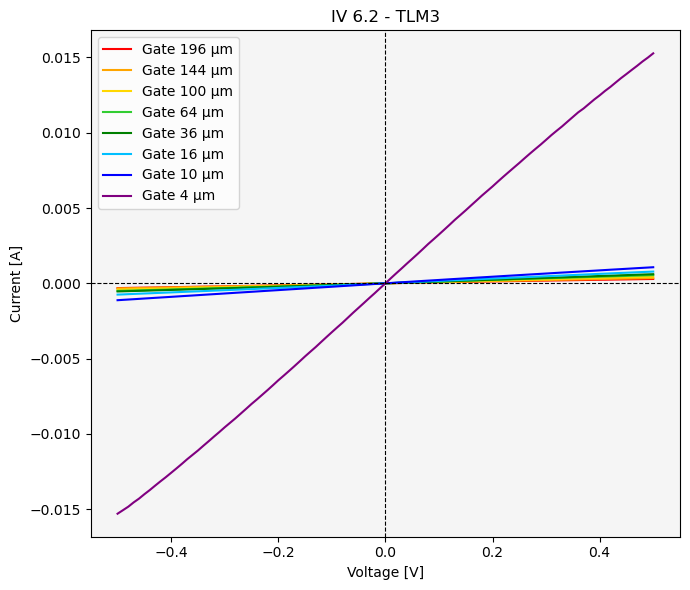

Measurment2txt_TLM3: slope = 0.000619133 A/V,  R = 1615.16 Ω, Measurment3txt_TLM3: slope = 0.000701796 A/V,  R = 1424.91 Ω, Measurment4txt_TLM3: slope = 0.000884758 A/V,  R = 1130.25 Ω, Measurment5txt_TLM3: slope = 0.00106206 A/V,  R = 941.565 Ω, Measurment6txt_TLM3: slope = 0.00115749 A/V,  R = 863.935 Ω, Measurment7txt_TLM3: slope = 0.00154034 A/V,  R = 649.209 Ω, Measurmenttxt_TLM3: slope = 0.00220151 A/V,  R = 454.234 Ω, Measurment8txt_TLM3: slope = 0.0313703 A/V,  R = 31.8772 Ω, 
=== 6.2 | TLM4 ===


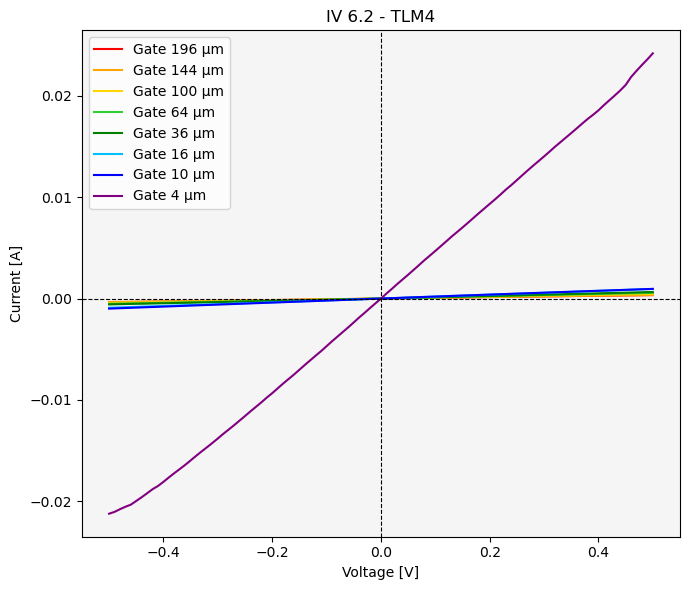

Measurment2txt_TLM4: slope = 0.000723121 A/V,  R = 1382.9 Ω, Measurment3txt_TLM4: slope = 0.000709926 A/V,  R = 1408.6 Ω, Measurment4txt_TLM4: slope = 0.000945924 A/V,  R = 1057.17 Ω, Measurment5txt_TLM4: slope = 0.00109196 A/V,  R = 915.784 Ω, Measurment6txt_TLM4: slope = 0.00122915 A/V,  R = 813.567 Ω, Measurment7txt_TLM4: slope = 0.00186494 A/V,  R = 536.21 Ω, Measurmenttxt_TLM4: slope = 0.00195382 A/V,  R = 511.817 Ω, Measurment8txt_TLM4: slope = 0.0459935 A/V,  R = 21.7422 Ω, 
=== 6.3 | TLM1 ===


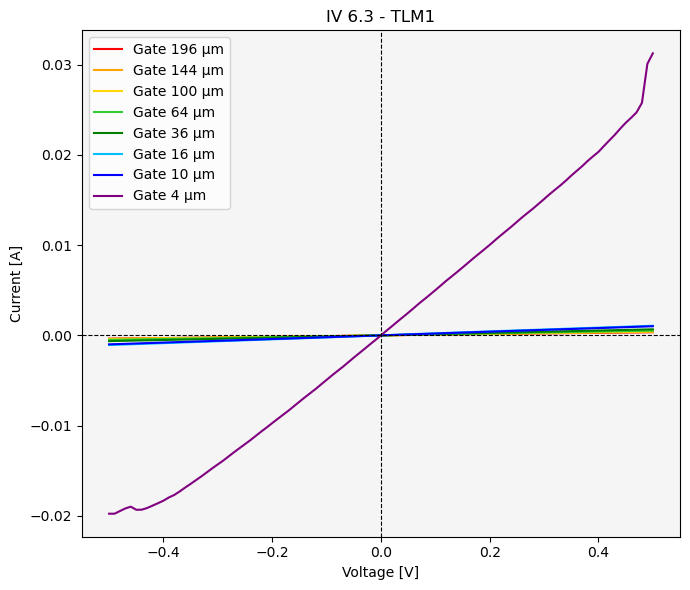

Measurment2txt_TLM1: slope = 0.000735822 A/V,  R = 1359.02 Ω, Measurment3txt_TLM1: slope = 0.000794426 A/V,  R = 1258.77 Ω, Measurment4txt_TLM1: slope = 0.000883574 A/V,  R = 1131.77 Ω, Measurment5txt_TLM1: slope = 0.00103509 A/V,  R = 966.102 Ω, Measurment6txt_TLM1: slope = 0.00131665 A/V,  R = 759.503 Ω, Measurment7txt_TLM1: slope = 0.002157 A/V,  R = 463.606 Ω, Measurmenttxt_TLM1: slope = 0.00201113 A/V,  R = 497.232 Ω, Measurment8txt_TLM1: slope = 0.048645 A/V,  R = 20.5571 Ω, 
=== 6.3 | TLM2 ===


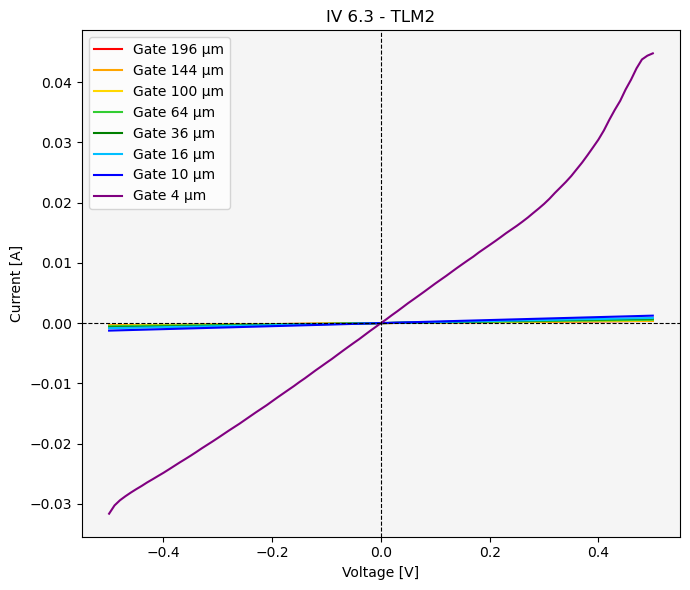

Measurment2txt_TLM2: slope = 0.000749852 A/V,  R = 1333.6 Ω, Measurment3txt_TLM2: slope = 0.000782018 A/V,  R = 1278.74 Ω, Measurment4txt_TLM2: slope = 0.000869443 A/V,  R = 1150.16 Ω, Measurment5txt_TLM2: slope = 0.00108191 A/V,  R = 924.294 Ω, Measurment6txt_TLM2: slope = 0.00148514 A/V,  R = 673.336 Ω, Measurment7txt_TLM2: slope = 0.00169735 A/V,  R = 589.152 Ω, Measurmenttxt_TLM2: slope = 0.00250008 A/V,  R = 399.988 Ω, Measurment8txt_TLM2: slope = 0.0699168 A/V,  R = 14.3027 Ω, 
=== 6.3 | TLM3 ===


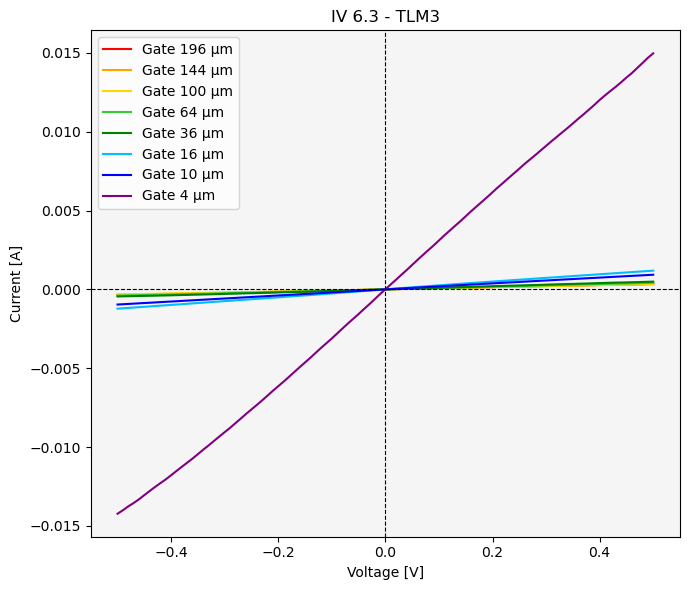

Measurment2txt_TLM3: slope = 0.000733277 A/V,  R = 1363.74 Ω, Measurment3txt_TLM3: slope = 0.000710635 A/V,  R = 1407.19 Ω, Measurment4txt_TLM3: slope = 0.000662142 A/V,  R = 1510.25 Ω, Measurment5txt_TLM3: slope = 0.00082205 A/V,  R = 1216.47 Ω, Measurment6txt_TLM3: slope = 0.000965264 A/V,  R = 1035.99 Ω, Measurment7txt_TLM3: slope = 0.00244004 A/V,  R = 409.829 Ω, Measurmenttxt_TLM3: slope = 0.00189909 A/V,  R = 526.568 Ω, Measurment8txt_TLM3: slope = 0.0298105 A/V,  R = 33.5452 Ω, 
=== 6.3 | TLM4 ===


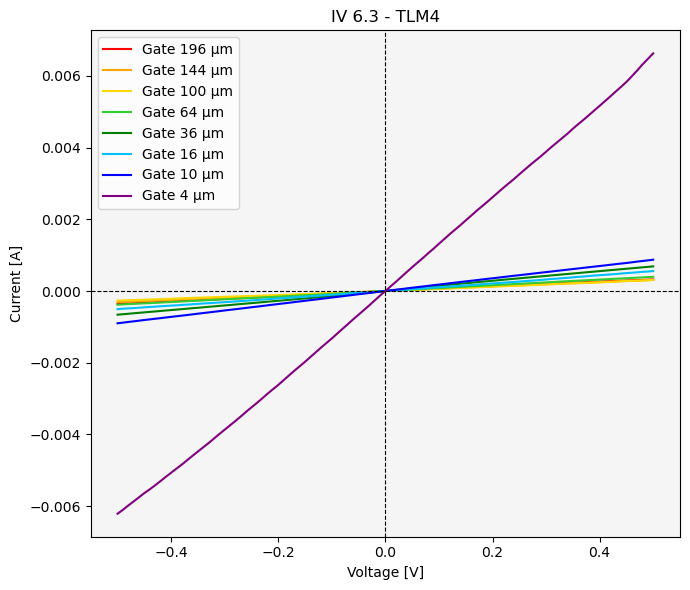

Measurment2txt_TLM4: slope = 0.00069722 A/V,  R = 1434.27 Ω, Measurment3txt_TLM4: slope = 0.000624388 A/V,  R = 1601.57 Ω, Measurment4txt_TLM4: slope = 0.000573538 A/V,  R = 1743.56 Ω, Measurment5txt_TLM4: slope = 0.000783471 A/V,  R = 1276.37 Ω, Measurment6txt_TLM4: slope = 0.00136268 A/V,  R = 733.846 Ω, Measurment7txt_TLM4: slope = 0.00105698 A/V,  R = 946.092 Ω, Measurmenttxt_TLM4: slope = 0.00177741 A/V,  R = 562.617 Ω, Measurment8txt_TLM4: slope = 0.0128535 A/V,  R = 77.7996 Ω, 
=== 6.4 | TLM1 ===


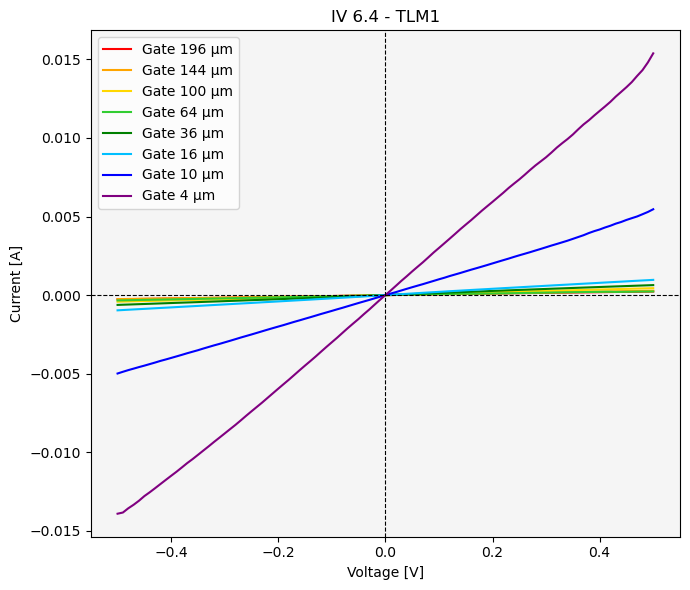

Measurment2txt_TLM1: slope = 0.000508632 A/V,  R = 1966.06 Ω, Measurment3txt_TLM1: slope = 0.000542364 A/V,  R = 1843.78 Ω, Measurment4txt_TLM1: slope = 0.000876873 A/V,  R = 1140.42 Ω, Measurment5txt_TLM1: slope = 0.00059427 A/V,  R = 1682.74 Ω, Measurment6txt_TLM1: slope = 0.00128088 A/V,  R = 780.713 Ω, Measurment7txt_TLM1: slope = 0.00196191 A/V,  R = 509.707 Ω, Measurmenttxt_TLM1: slope = 0.0102103 A/V,  R = 97.9401 Ω, Measurment8txt_TLM1: slope = 0.0291944 A/V,  R = 34.2532 Ω, 
=== 6.4 | TLM2 ===


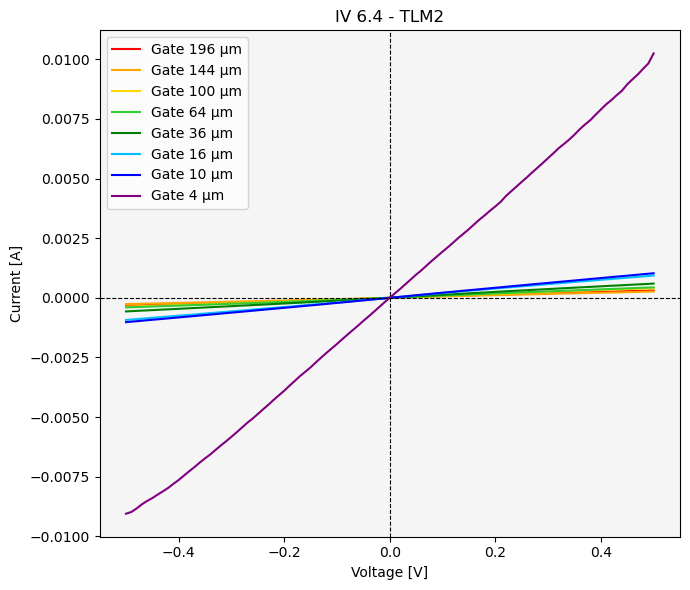

Measurment2txt_TLM2: slope = 0.000660743 A/V,  R = 1513.45 Ω, Measurment3txt_TLM2: slope = 0.000535304 A/V,  R = 1868.1 Ω, Measurment4txt_TLM2: slope = 0.000791973 A/V,  R = 1262.67 Ω, Measurment5txt_TLM2: slope = 0.000854971 A/V,  R = 1169.63 Ω, Measurment6txt_TLM2: slope = 0.00118345 A/V,  R = 844.99 Ω, Measurment7txt_TLM2: slope = 0.00188739 A/V,  R = 529.833 Ω, Measurmenttxt_TLM2: slope = 0.0020678 A/V,  R = 483.605 Ω, Measurment8txt_TLM2: slope = 0.0193325 A/V,  R = 51.7265 Ω, 
=== 6.4 | TLM3 ===


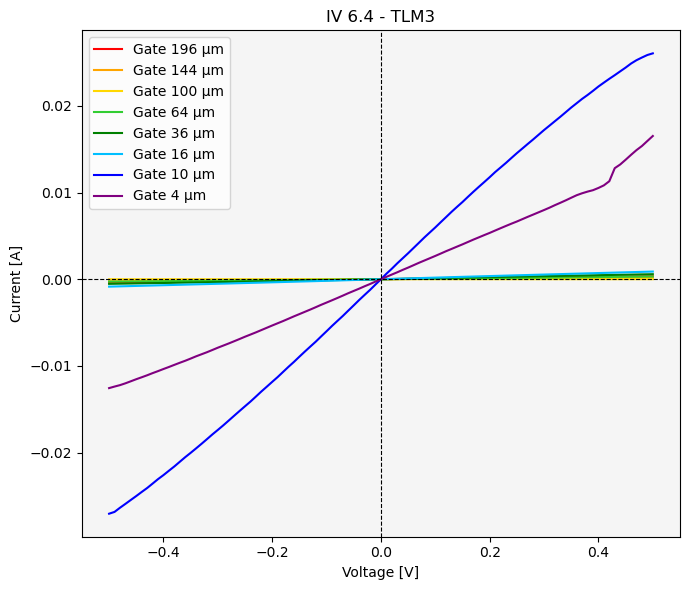

Measurment2txt_TLM3: slope = 0.000747376 A/V,  R = 1338.02 Ω, Measurment3txt_TLM3: slope = 0.00047053 A/V,  R = 2125.26 Ω, Measurment4txt_TLM3: slope = 1.05201e-05 A/V,  R = 95056 Ω, Measurment5txt_TLM3: slope = 0.000589774 A/V,  R = 1695.56 Ω, Measurment6txt_TLM3: slope = 0.00112704 A/V,  R = 887.281 Ω, Measurment7txt_TLM3: slope = 0.00175987 A/V,  R = 568.224 Ω, Measurmenttxt_TLM3: slope = 0.0561112 A/V,  R = 17.8218 Ω, Measurment8txt_TLM3: slope = 0.0272858 A/V,  R = 36.6491 Ω, 
=== 6.4 | TLM4 ===


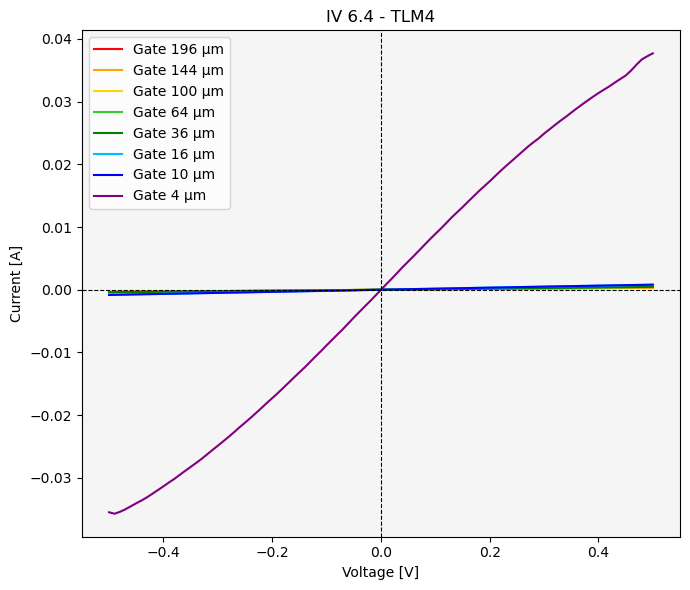

Measurment2txt_TLM4: slope = 0.000689 A/V,  R = 1451.38 Ω, Measurment3txt_TLM4: slope = 0.000695834 A/V,  R = 1437.12 Ω, Measurment4txt_TLM4: slope = 0.000743588 A/V,  R = 1344.83 Ω, Measurment5txt_TLM4: slope = 0.000869301 A/V,  R = 1150.35 Ω, Measurment6txt_TLM4: slope = 0.00086128 A/V,  R = 1161.06 Ω, Measurment7txt_TLM4: slope = 0.00162864 A/V,  R = 614.01 Ω, Measurmenttxt_TLM4: slope = 0.00164618 A/V,  R = 607.467 Ω, Measurment8txt_TLM4: slope = 0.0791586 A/V,  R = 12.6329 Ω, 
=== 7.1 | TLM1 ===


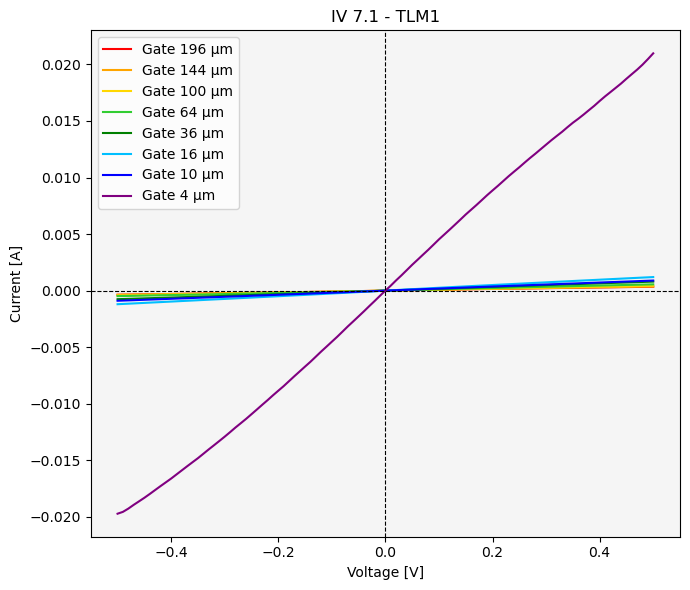

Measurment2txt_TLM1: slope = 0.000729163 A/V,  R = 1371.44 Ω, Measurment3txt_TLM1: slope = 0.00074892 A/V,  R = 1335.26 Ω, Measurment4txt_TLM1: slope = 0.000884647 A/V,  R = 1130.39 Ω, Measurment5txt_TLM1: slope = 0.00106204 A/V,  R = 941.587 Ω, Measurment6txt_TLM1: slope = 0.00157709 A/V,  R = 634.081 Ω, Measurment7txt_TLM1: slope = 0.00242551 A/V,  R = 412.285 Ω, Measurmenttxt_TLM1: slope = 0.00179873 A/V,  R = 555.947 Ω, Measurment8txt_TLM1: slope = 0.0420247 A/V,  R = 23.7956 Ω, 
=== 7.1 | TLM2 ===


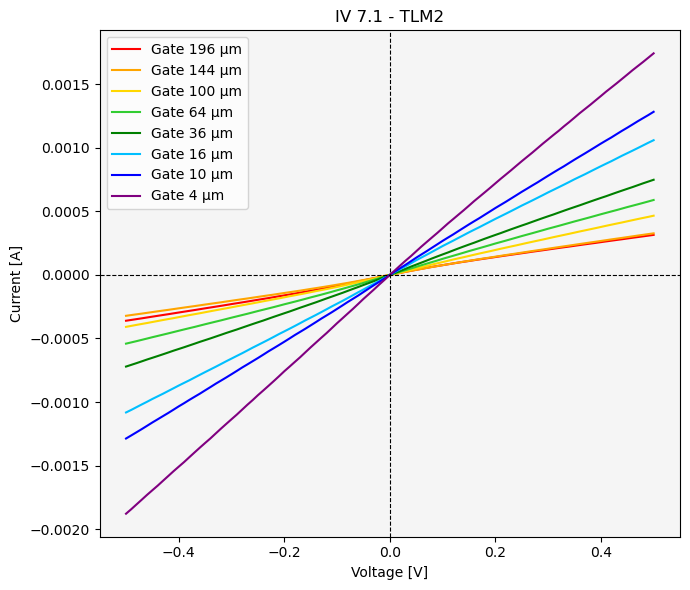

Measurment2txt_TLM2: slope = 0.00070165 A/V,  R = 1425.21 Ω, Measurment3txt_TLM2: slope = 0.000670809 A/V,  R = 1490.74 Ω, Measurment4txt_TLM2: slope = 0.000893693 A/V,  R = 1118.95 Ω, Measurment5txt_TLM2: slope = 0.00115306 A/V,  R = 867.255 Ω, Measurment6txt_TLM2: slope = 0.00149392 A/V,  R = 669.38 Ω, Measurment7txt_TLM2: slope = 0.0021659 A/V,  R = 461.702 Ω, Measurmenttxt_TLM2: slope = 0.00259112 A/V,  R = 385.933 Ω, Measurment8txt_TLM2: slope = 0.00365246 A/V,  R = 273.788 Ω, 
=== 7.1 | TLM3 ===


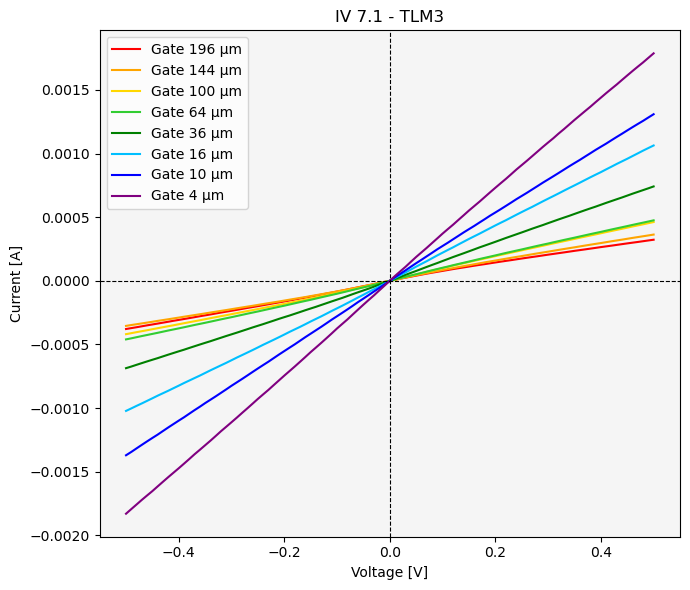

Measurment2txt_TLM3: slope = 0.000722234 A/V,  R = 1384.59 Ω, Measurment3txt_TLM3: slope = 0.000740168 A/V,  R = 1351.04 Ω, Measurment4txt_TLM3: slope = 0.000899782 A/V,  R = 1111.38 Ω, Measurment5txt_TLM3: slope = 0.000953091 A/V,  R = 1049.22 Ω, Measurment6txt_TLM3: slope = 0.00144531 A/V,  R = 691.893 Ω, Measurment7txt_TLM3: slope = 0.00210402 A/V,  R = 475.28 Ω, Measurmenttxt_TLM3: slope = 0.00269375 A/V,  R = 371.23 Ω, Measurment8txt_TLM3: slope = 0.00364332 A/V,  R = 274.475 Ω, 
=== 7.1 | TLM4 ===


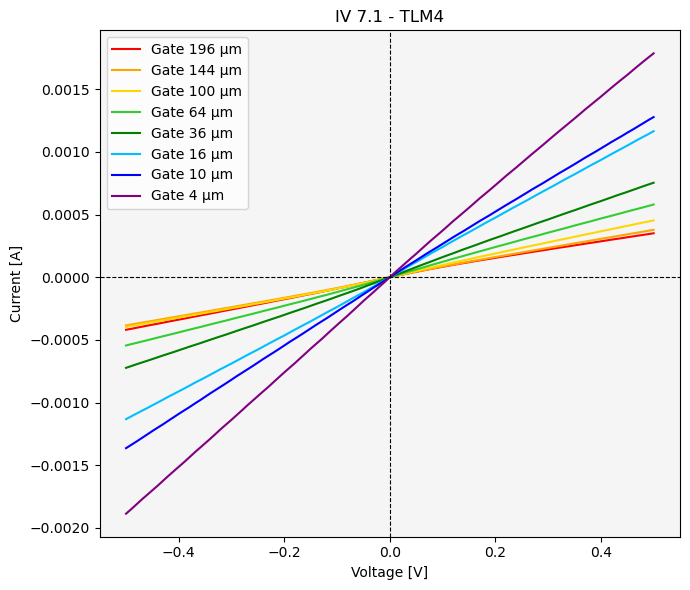

Measurment2txt_TLM4: slope = 0.000787676 A/V,  R = 1269.56 Ω, Measurment3txt_TLM4: slope = 0.00077856 A/V,  R = 1284.42 Ω, Measurment4txt_TLM4: slope = 0.000866303 A/V,  R = 1154.33 Ω, Measurment5txt_TLM4: slope = 0.00113996 A/V,  R = 877.227 Ω, Measurment6txt_TLM4: slope = 0.00149505 A/V,  R = 668.874 Ω, Measurment7txt_TLM4: slope = 0.00231408 A/V,  R = 432.137 Ω, Measurmenttxt_TLM4: slope = 0.0026509 A/V,  R = 377.23 Ω, Measurment8txt_TLM4: slope = 0.00369688 A/V,  R = 270.499 Ω, 
=== 7.2 | TLM1 ===


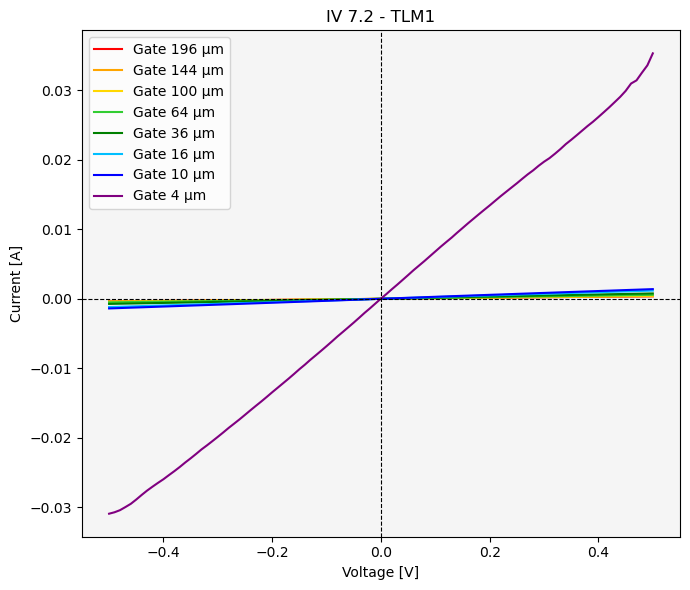

Measurment2txt_TLM1: slope = 0.000756343 A/V,  R = 1322.15 Ω, Measurment3txt_TLM1: slope = 0.000761347 A/V,  R = 1313.46 Ω, Measurment4txt_TLM1: slope = 0.000913284 A/V,  R = 1094.95 Ω, Measurment5txt_TLM1: slope = 0.00110163 A/V,  R = 907.742 Ω, Measurment6txt_TLM1: slope = 0.00153179 A/V,  R = 652.831 Ω, Measurment7txt_TLM1: slope = 0.00239021 A/V,  R = 418.374 Ω, Measurmenttxt_TLM1: slope = 0.00279672 A/V,  R = 357.562 Ω, Measurment8txt_TLM1: slope = 0.0656853 A/V,  R = 15.2241 Ω, 
=== 7.2 | TLM2 ===


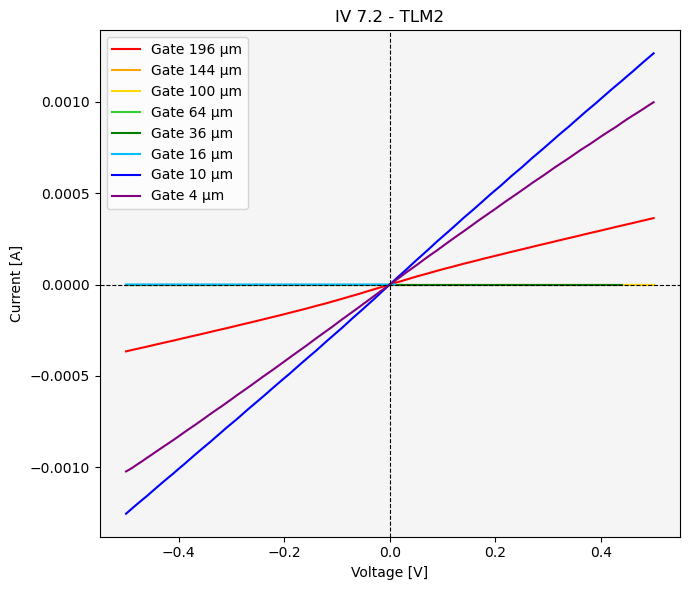

Measurment2txt_TLM2: slope = 0.000751471 A/V,  R = 1330.72 Ω, Measurment3txt_TLM2: slope = 4.91282e-14 A/V,  R = 2.03549e+13 Ω, Measurment4txt_TLM2: slope = 1.67434e-11 A/V,  R = 5.97249e+10 Ω, Measurment5txt_TLM2: slope = 5.84163e-11 A/V,  R = 1.71185e+10 Ω, Measurment6txt_TLM2: slope = 2.87412e-10 A/V,  R = 3.47932e+09 Ω, Measurment7txt_TLM2: slope = 1.91407e-09 A/V,  R = 5.22447e+08 Ω, Measurmenttxt_TLM2: slope = 0.00253416 A/V,  R = 394.608 Ω, Measurment8txt_TLM2: slope = 0.00205004 A/V,  R = 487.796 Ω, 
=== 7.2 | TLM3 ===


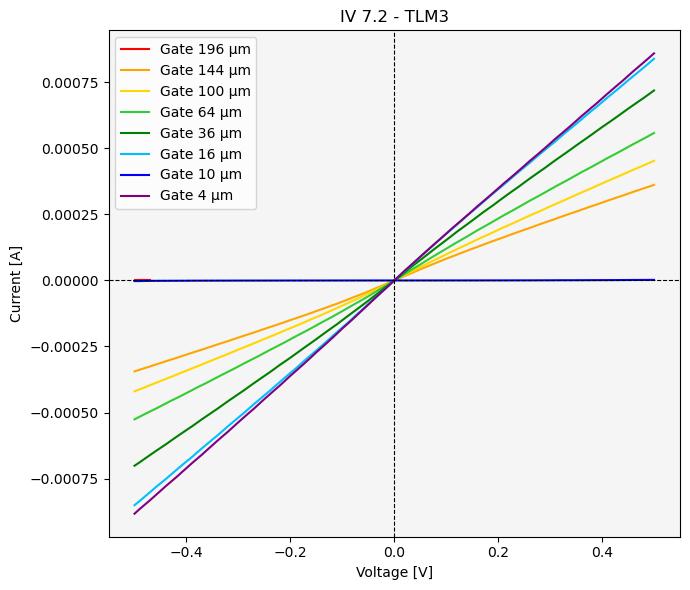

Measurment2txt_TLM3: slope = 4.164e-12 A/V,  R = 2.40154e+11 Ω, Measurment3txt_TLM3: slope = 0.000726536 A/V,  R = 1376.39 Ω, Measurment4txt_TLM3: slope = 0.000892496 A/V,  R = 1120.45 Ω, Measurment5txt_TLM3: slope = 0.00110432 A/V,  R = 905.534 Ω, Measurment6txt_TLM3: slope = 0.0014402 A/V,  R = 694.347 Ω, Measurment7txt_TLM3: slope = 0.00170665 A/V,  R = 585.943 Ω, Measurmenttxt_TLM3: slope = 2.86747e-06 A/V,  R = 348740 Ω, Measurment8txt_TLM3: slope = 0.00175367 A/V,  R = 570.233 Ω, 
=== 7.2 | TLM4 ===


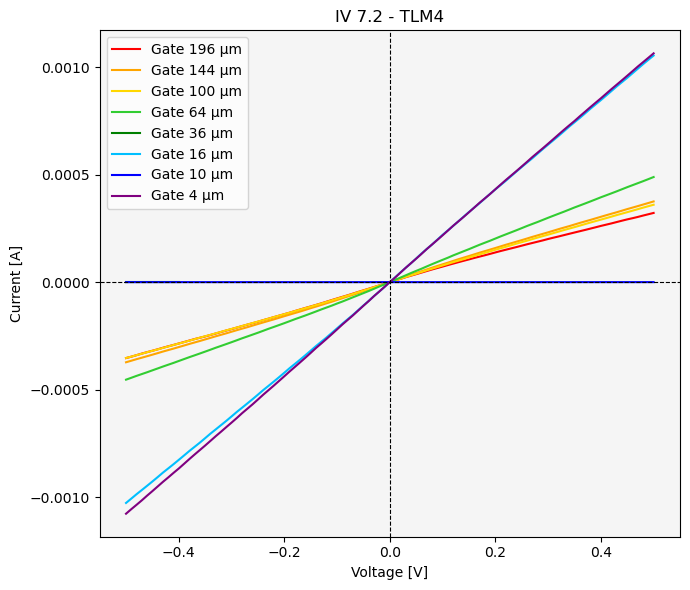

Measurment2txt_TLM4: slope = 0.00068892 A/V,  R = 1451.55 Ω, Measurment3txt_TLM4: slope = 0.00076295 A/V,  R = 1310.7 Ω, Measurment4txt_TLM4: slope = 0.000725034 A/V,  R = 1379.25 Ω, Measurment5txt_TLM4: slope = 0.000956405 A/V,  R = 1045.58 Ω, Measurment6txt_TLM4: slope = 1.00854e-12 A/V,  R = 9.91536e+11 Ω, Measurment7txt_TLM4: slope = 0.00209857 A/V,  R = 476.514 Ω, Measurmenttxt_TLM4: slope = 2.98979e-08 A/V,  R = 3.34471e+07 Ω, Measurment8txt_TLM4: slope = 0.00215533 A/V,  R = 463.965 Ω, 

{'Measurment2txt_TLM1': {'slope_A_per_V': 0.002595430954222481,
  'R_ohm': 385.29246881837093},
 'Measurment3txt_TLM1': {'slope_A_per_V': 0.0008622251132789751,
  'R_ohm': 1159.789925622878},
 'Measurment4txt_TLM1': {'slope_A_per_V': 0.0009972023623179966,
  'R_ohm': 1002.8054864165186},
 'Measurment5txt_TLM1': {'slope_A_per_V': 0.0012102311913220734,
  'R_ohm': 826.2884043730405},
 'Measurment6txt_TLM1': {'slope_A_per_V': 0.0015291821941176471,
  'R_ohm': 653.944313402766},
 'Measurment7txt_TLM1': {'slope_A_per_V': 0.0021364175224810713,
  'R_ohm': 468.0733000348531},
 'Measurmenttxt_TLM1': {'slope_A_per_V': 0.0008128442593476994,
  'R_ohm': 1230.2479700139502},
 'Measurment8txt_TLM1': {'slope_A_per_V': 0.13526875569598137,
  'R_ohm': 7.392690165994544}}

In [27]:
# SET UP LABELS, DEVICES, AND LEGENDS

"""
label_dict:
This maps each TLM subfolder (TLM1, TLM2, TLM3, TLM4) to the filenames it contains.

- Keys = folder names
- Values = list of file labels that you cleaned with extract_final_data()
           (here they look like "Measurement2txt_TLM1", etc.)

This dictionary tells run_device() which IV curves to plot for each subfolder.
"""

label_dict = {
    "TLM1": [
        "Measurment2txt_TLM1",
        "Measurment3txt_TLM1",
        "Measurment4txt_TLM1",
        "Measurment5txt_TLM1",
        "Measurment6txt_TLM1",
        "Measurment7txt_TLM1",
        "Measurmenttxt_TLM1",
        "Measurment8txt_TLM1",],
    "TLM2": [
        "Measurment2txt_TLM2",
        "Measurment3txt_TLM2",
        "Measurment4txt_TLM2",
        "Measurment5txt_TLM2",
        "Measurment6txt_TLM2",
        "Measurment7txt_TLM2",
        "Measurmenttxt_TLM2",
        "Measurment8txt_TLM2",],
    "TLM3": [
        "Measurment2txt_TLM3",
        "Measurment3txt_TLM3",
        "Measurment4txt_TLM3",
        "Measurment5txt_TLM3",
        "Measurment6txt_TLM3",
        "Measurment7txt_TLM3",
        "Measurmenttxt_TLM3",
        "Measurment8txt_TLM3",],
    "TLM4": [
        "Measurment2txt_TLM4",
        "Measurment3txt_TLM4",
        "Measurment4txt_TLM4",
        "Measurment5txt_TLM4",
        "Measurment6txt_TLM4",
        "Measurment7txt_TLM4",
        "Measurmenttxt_TLM4",
        "Measurment8txt_TLM4",]
}


"""
root_dir:
The folder on your computer that contains all the device folders.
Each device folder (e.g. "4.1", "4.2", ...) will have subfolders TLM1–TLM4.

devices:
A list of device IDs. These match folder names inside root_dir.

subfolders:
The subfolders you want to loop through inside each device directory.
Here: TLM1, TLM2, TLM3, TLM4.
"""
root_dir   = r"C:\Users\julia\OneDrive\Documents\Work\tyndall\python\TLM DATA"
devices    = ["4.1","4.2","4.3","4.4", "5.1", "5.2","5.3","5.4",
              "6.1","6.2","6.3","6.4","7.1","7.2"]
subfolders = ["TLM1","TLM2", "TLM3", "TLM4"]


"""
legend:
Names that will show up in the plot legend, in the same order as label_dict entries.
Make sure the number of legend entries matches the number of labels in label_dict.
"""
legend = [
        "Gate 196 µm", "Gate 144 µm", "Gate 100 µm", "Gate 64 µm",
        "Gate 36 µm", "Gate 16 µm", "Gate 10 µm", "Gate 4 µm"
    ]


#RUN EVERYTHING

"""
all_results:
We’ll store results here as a dictionary.
Key = (device, TLM subfolder)
Value = dictionary of fit results returned by run_device().
"""
all_results = {}

# Loop through each device
for dev in devices:
    device_dir = os.path.join(root_dir, dev)   # full path to this device folder
    
    # Loop through each TLM subfolder
    for title, labels in label_dict.items():
        print(f"\n=== {dev} | {title} ===")  # nice header for console output

        # Run the full pipeline: collect → load → extract → plot
        results = run_device(
            device_dir,
            subfolders,     # list of subfolders (TLM1–TLM4)
            labels,         # labels to plot inside this subfolder
            legend,         # legend text for each curve
            title=f"IV {dev} - {title}",  # plot title
            xlim=None,      # you can set limits like (0,1) to zoom
            ylim=None
        )

        # Save results so you can look them up later
        all_results[(dev, title)] = results


"""
END RESULT:
 - For each device (4.1, 4.2, …) and each TLM subfolder (TLM1–TLM4):
   * A clean IV plot is made with all curves on the same axes.
   * Slopes and resistances are printed in the console.
   * Values are saved into all_results[(device, TLM)].

Example lookup:
   all_results[("4.1", "TLM1")]
will give you the fit data for device 4.1 in TLM1.
"""

all_results[("4.1", "TLM1")]


In [28]:

# STEP 10: COLLECT AND PLOT TLM DATA ACROSS ALL DEVICES


"""
SPACING_MAP:
Here we map spacing in micrometers.
Example: "Measurment8txt_TLM1" → first number is "8" → spacing = 4 µm
"""
SPACING_MAP = {
    "2": 196, "3": 144, "4": 100, "5": 64,
    "6": 36,  "7": 16,  "1": 10,  "8": 4
}

"""
SPACING_ORDER:
Fixed order of spacing values so colors and legend entries are consistent.
"""
SPACING_ORDER = [196, 144, 100, 64, 36, 16, 10, 4]


# ---------- LABEL PARSING HELPERS ----------
def _first_digit_in(s):
    """
    Return the first run of digits found in string s.
    If none found, return None.
    """
    m = re.search(r"(\d+)", s)
    return m.group(1) if m else None


def extract_spacing_um_from_label(label):
    """
    Labels look like 'Measurment8txt_TLM1'.
    Strategy:
      1) Split on '_' and take the first part (prefix)
      2) Find the first number in that prefix
      3) Use SPACING_MAP to convert that number to micrometers

    Returns:
      spacing in micrometers, or None if it cannot be parsed
    """
    prefix = label.split("_")[0]
    idx = _first_digit_in(prefix)
    return SPACING_MAP.get(idx, None)


# ---------- GATHER ALL TLM POINTS FROM RESULTS ----------
def collect_all_spacing_R(all_results: dict):
    """
    Build concatenated arrays of spacing d [µm] and resistance R [Ω] 
    from the results produced by run_device.

    Input:
      all_results[(device, tlm_name)] → { label → {"R_ohm": value, ...}, ... }

    Output:
      d_all : np.ndarray of spacings in micrometers
      R_all : np.ndarray of absolute resistances in ohms

      - Skips entries with non finite R
    """
    d_list = []
    R_list = []

    for (_dev, _tlm), res in all_results.items():
        if not isinstance(res, dict):
            continue
        for lab, vals in res.items():
            # Pull R 
            R = vals.get("R_ohm", np.nan)
            if R is None or not np.isfinite(R):
                continue

            # Get spacing from label like 'Measurment8txt_TLM1'
            s_um = extract_spacing_um_from_label(lab)
            if s_um is None:
                continue

            d_list.append(float(s_um))
            R_list.append(float(abs(R)))  # use magnitude 

    return np.array(d_list, dtype=float), np.array(R_list, dtype=float)


#FILTERS, FIT, AND PLOTTING


# ---------- OUTLIER FILTERS USING MAD ----------
def _mad(arr):
    """
    Median Absolute Deviation scaled by 1.4826
    This acts like a robust standard deviation for Gaussian data.
    """
    med = np.median(arr)
    mad = np.median(np.abs(arr - med))
    return 1.4826 * mad


def _apply_single_mad_filter(d, R, thresh=3.0):
    """
    Global MAD filter:
      Keep points whose R is within thresh * MAD of the global median.
    """
    med = np.median(R)
    mad = _mad(R)
    mad = mad if mad > 0 else 1e-12
    keep = np.abs(R - med) < thresh * mad
    return d[keep], R[keep]


def _apply_double_mad_filter(d, R, global_thresh=3.0, local_thresh=2.5):
    """
    Two stage filter:
      1) Global MAD filter to remove extreme outliers
      2) Per spacing MAD filter to clean up each group
    """
    # Step 1: global
    d1, R1 = _apply_single_mad_filter(d, R, thresh=global_thresh)

    # Group by spacing
    grouped = defaultdict(list)
    for di, Ri in zip(d1, R1):
        grouped[di].append(Ri)

    # Step 2: local within each spacing
    d2, R2 = [], []
    for di, grp in grouped.items():
        g = np.array(grp, dtype=float)
        g_med = np.median(g)
        g_mad = _mad(g)
        g_mad = g_mad if g_mad > 0 else 1e-12
        keep = np.abs(g - g_med) < local_thresh * g_mad
        d2.extend([di] * int(np.sum(keep)))
        R2.extend(g[keep])

    return np.array(d2, dtype=float), np.array(R2, dtype=float)


# ---------- LINEAR TLM FIT AND COLOR HELP ----------
def _tlm_fit(d_um, R_ohm, w_um):
    """
    Linear model: R = m*d + b
       m = slope (Ω per µm)
       b = intercept (Ω) which equals 2*Rc
       Rs = m * w  (Ω per square)
       Rc = b / 2  (Ω)

    Returns:
      m, b, Rs, Rc
    """
    m, b = np.polyfit(d_um, R_ohm, 1)   # R = m*d + b
    Rs = m * float(w_um)                # sheet resistance
    Rc = b / 2.0                        # contact resistance
    return m, b, Rs, Rc


def _color_for_spacing(s, colors, spacing_order=SPACING_ORDER):
    """
    Assign a stable color based on where spacing s appears in spacing_order.
    """
    try:
        i = spacing_order.index(int(s))
    except ValueError:
        i = 0
    return colors[i % len(colors)]


# ---------- MAIN PLOTTING ENTRY POINT ----------
def plot_all_tlm_one_figure(d_all, R_all, *,
                            w_um,
                            method="none",           # 'none', 'single', 'double'
                            title="TLM: all devices",
                            ylim=None,
                            show_spacing_legend=True,
                            show_fit_info=True,
                            colors=("red","orange","gold","limegreen","green",
                                    "deepskyblue","blue","purple","pink"),
                            spacing_order=SPACING_ORDER):
    """
    Make one TLM plot from many points gathered across devices.

    Inputs:
      d_all : array of spacings [µm]
      R_all : array of resistances [Ω]
      w_um  : line width used to compute Rs
      method : choose outlier filter
      title  : figure title
      ylim   : optional y axis limits as (ymin, ymax)
      show_spacing_legend : show colored points per spacing in legend
      show_fit_info       : add fit equation and Rs, Rc to legend
      colors              : color palette
      spacing_order       : order used for consistent color mapping

    Output:
      dict with slope, intercept, Rs, Rc
    """
    # Choose which data to use, based on filter method
    if method == "single":
        d_use, R_use = _apply_single_mad_filter(d_all, R_all, thresh=3.0)
        subtitle = "(single MAD filter)"
    elif method == "double":
        d_use, R_use = _apply_double_mad_filter(d_all, R_all, global_thresh=3.0, local_thresh=2.5)
        subtitle = "(double MAD filter)"
    else:
        d_use, R_use = np.array(d_all, dtype=float), np.array(R_all, dtype=float)
        subtitle = "(no filter)"

    # Need at least two points for a reliable fit
    if d_use.size < 2:
        print("Not enough points to plot.")
        return

    # Fit the TLM line
    m, b, Rs, Rc = _tlm_fit(d_use, R_use, w_um=w_um)

    # Build the figure
    fig, ax = plt.subplots(figsize=(7, 6))
    present = sorted(set(d_use))   # which spacings are present in the data
    spacing_handles = []

    # Draw points grouped by spacing with stable colors
    for s in spacing_order:
        if s in present:
            mask = d_use == s
            ax.scatter(d_use[mask], R_use[mask],
                       s=22, alpha=0.9,
                       color=_color_for_spacing(s, colors, spacing_order),
                       label=f"{s} µm")
            if show_spacing_legend:
                spacing_handles.append(
                    Line2D([0],[0], marker='o', linestyle='None',
                           color=_color_for_spacing(s, colors, spacing_order),
                           label=f"{s} µm")
                )

    # Draw the fitted line across the span of observed spacings
    dline = np.linspace(d_use.min(), d_use.max(), 300)
    ax.plot(dline, m*dline + b, "k--", lw=1.5)

    # Labels and styling
    ax.set_xlabel("Spacing d [µm]")
    ax.set_ylabel("Resistance R [Ω]")
    ax.set_title(f"{title} {subtitle}")
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_facecolor("#f5f5f5")
    ax.set_xticks(sorted(present), [f"{int(s)}" for s in sorted(present)])

    # Compose legend entries
    legend_handles = []
    if show_spacing_legend:
        legend_handles += spacing_handles
    if show_fit_info:
        fit_handle = Line2D([0],[0], color='black', linestyle='--',
                            label=f"Fit: R = {m:.2f}·d + {b:.2f} Ω")
        rs_rc_handle = Line2D([0],[0], linestyle='None', color='none',
                              label=rf"$R_s$ ≈ {Rs:.0f} Ω/□   $R_c$ ≈ {Rc:.0f} Ω")
        legend_handles += [fit_handle, rs_rc_handle]
    if legend_handles:
        ax.legend(handles=legend_handles, loc="best", fontsize=9)

    plt.tight_layout()
    plt.show()

    # Return numbers so you can log them or compare methods
    return {"slope_ohm_per_um": m,
            "intercept_ohm": b,
            "Rs_ohm_per_sq": Rs,
            "Rc_ohm": Rc}


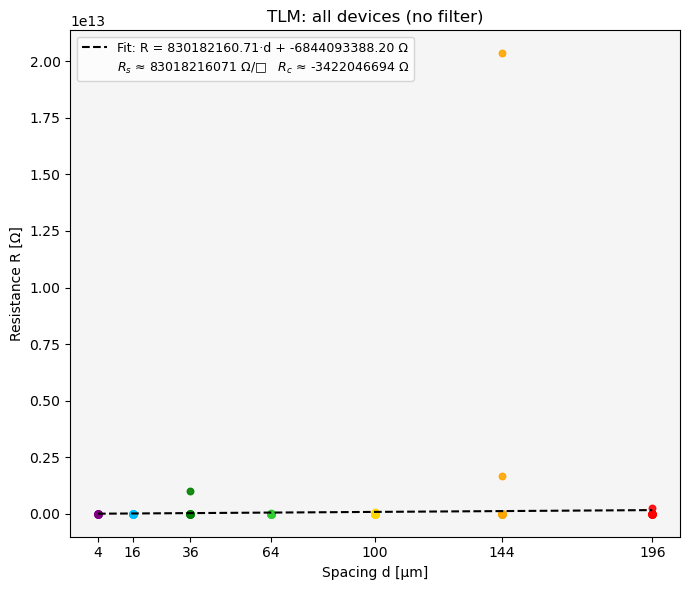

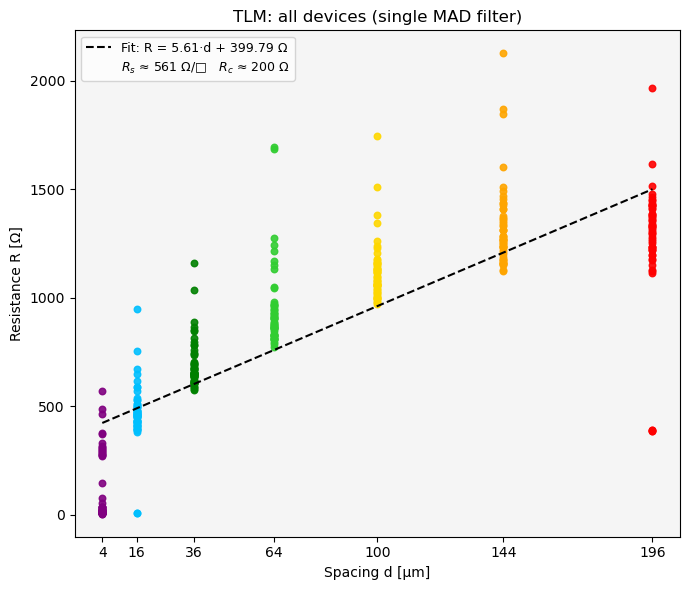

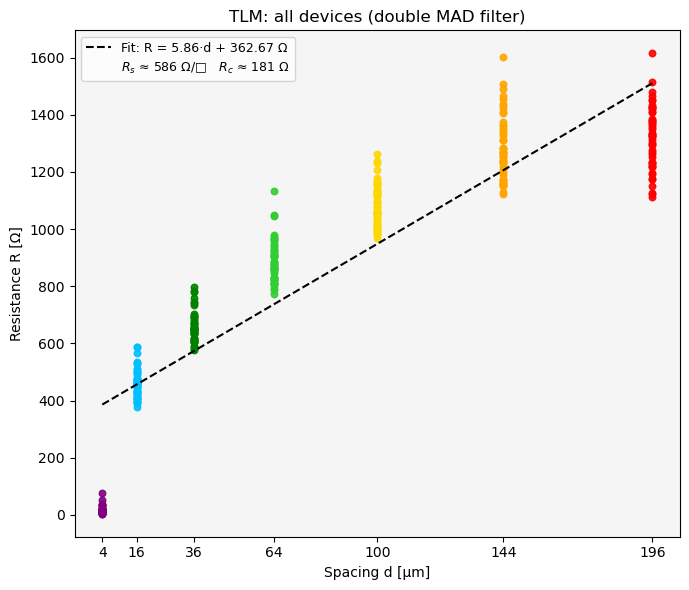

{'slope_ohm_per_um': 5.859775724523333,
 'intercept_ohm': 362.668063845687,
 'Rs_ohm_per_sq': 585.9775724523333,
 'Rc_ohm': 181.3340319228435}

In [29]:
# gather everything
d_all, R_all = collect_all_spacing_R(all_results)

# set your actual TLM line width here
W_MICRONS = 100

# one figure per filter method, all devices + all TLMs combined
plot_all_tlm_one_figure(d_all, R_all, w_um=100, method="none",
                        show_spacing_legend=False, show_fit_info=True)
plot_all_tlm_one_figure(d_all, R_all, w_um=100, method="single",
                        show_spacing_legend=False, show_fit_info=True)

plot_all_tlm_one_figure(d_all, R_all, w_um=100, method="double",
                        show_spacing_legend=False, show_fit_info=True)



In [35]:
# Gather raw data
d_all, R_all = collect_all_spacing_R(all_results)

print("=== Raw (no filter) ===")
print("R_all:", R_all)

# Apply single MAD filter
d_single, R_single = _apply_single_mad_filter(d_all, R_all, thresh=3.0)
print("\n=== After single MAD filter ===")
print("R_single:", R_single)

# Apply double MAD filter
d_double, R_double = _apply_double_mad_filter(d_all, R_all, global_thresh=3.0, local_thresh=2.5)
print("\n=== After double MAD filter ===")
print("R_double:", R_double)


=== Raw (no filter) ===
R_all: [3.85292469e+02 1.15978993e+03 1.00280549e+03 8.26288404e+02
 6.53944313e+02 4.68073300e+02 7.39269017e+00 3.90892082e+02
 1.17195567e+03 1.04003733e+03 8.08334389e+02 6.12106135e+02
 4.30836776e+02 7.24680179e+00 1.17606001e+03 1.15451223e+03
 9.98995715e+02 8.08916400e+02 6.14130091e+02 4.35847513e+02
 2.81148599e+02 1.11404600e+03 1.15699981e+03 1.05748053e+03
 8.13355616e+02 6.40711309e+02 4.77052175e+02 3.74620655e+02
 1.30032925e+03 1.25235504e+03 1.11958683e+03 8.63177838e+02
 6.45430885e+02 4.48671045e+02 2.91987465e+02 3.90096072e+02
 1.50784183e+03 1.17131831e+03 1.13325721e+03 6.46216835e+02
 4.70350443e+02 3.09656858e+02 3.82915459e+02 1.25160098e+03
 1.07658480e+03 8.61054059e+02 6.53926537e+02 4.58347763e+02
 3.28488724e+02 1.32516899e+03 1.26910231e+03 1.02536253e+03
 8.34203835e+02 6.32416901e+02 4.47695050e+02 2.89018126e+02
 1.40895692e+03 1.23526412e+03 1.06077253e+03 8.58165092e+02
 6.50917113e+02 4.55021021e+02 3.03800273e+02 1.478649

In [38]:

# EXPORT IV DATA TO EXCEL (ONE OR MANY)

"""
This cell shows two approaches:

1) Export a single IV curve (one label) into its own Excel file,
   saved in a folder of your choice.

2) Export all IV curves from final_data into one Excel workbook,
   with each curve in its own sheet.

You can adapt the save_dir to point to wherever you want.
"""

# ---------- SETTINGS ----------
save_dir = r"C:\Users\julia\OneDrive\Documents\Work\tyndall\python\excel"
os.makedirs(save_dir, exist_ok=True)   # make sure folder exists

df_all = pd.DataFrame({
    "Spacing": d_all,
    "R No Filter": R_all,
})

df_single = pd.DataFrame({
    "Spacing": d_single,
    "R Single": R_single,
})

df_double = pd.DataFrame({
    "Spacing": d_double,
    "R Double": R_double,
})

output_path = os.path.join(save_dir, "TLM_resistances.xlsx")

# --- Save to one Excel with multiple sheets ---
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    df_all.to_excel(writer, sheet_name="No Filter", index=False)
    df_single.to_excel(writer, sheet_name="Single MAD", index=False)
    df_double.to_excel(writer, sheet_name="Double MAD", index=False)

print(f"Saved resistances to: {output_path}")





Saved resistances to: C:\Users\julia\OneDrive\Documents\Work\tyndall\python\excel\TLM_resistances.xlsx
